# Project: Insurance Fraud Detection (DS)
---------------------------------------------

**Dr. Dave Wanik - OPIM 5512: Data Science Using Python - University of Connecticut**

*This dataset comes from the 2023 NESS Statathon (Theme 1). Here is a link to where the live competition is being hosted - feel free to join!*
* https://www.kaggle.com/competitions/2023-travelers-ness-statathon/overview

**Challenge:** You work for Travelers Insurance Company's fraud detection department as a modeler. Your colleagues, who are not familiar with statistics, would like you to create a predictive model based on historical claim data. Your team is concerned about the fraud detection accuracy as well as the key drivers that cause fraudulence.

For this case competition, your group is tasked with identifying first-party physical damage fraudulence and explaining the indicators of fraudulent claims.
  * Make sure you use the 'weighted' F1 score - you can just print this using the classification report (bottom right corner).
    * https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

# Dataset Description
All first-party physical damage claims will be filtered by claim handlers and some of them will be referred to the fraud detection team. Your data is a sample of these referred claims from 2015 to 2016.

As a simplification, you are just going to work with the train dataset (linked below). This is because it has the answers! All teams will use the same random_seed to split the data into train and test - Dave will do this part for you. You may not delete rows in the test partition, use `transform()` to update rows in test partition, you can do almost anything you want on the train partition. If there is data leakage, you automatically go into last place (more on that later.)

Your work is to build a model on the training data and apply your model to predict the fraud indicator for each claim in the test data.

**Variable Descriptions**
* claim_number - Claim ID **(cannot be used in model)**
* age_of_driver - Age of driver
* gender - Gender of driver
* marital_status - Marital status of driver
* safty_rating - Safety rating index of driver
* annual_income - Annual income of driver
* high_education_ind - Driver’s high education index
* address_change_ind - Whether or not the driver changed living address in past 1 year
* living_status - Driver’s living status, own or rent
* zip_code - Driver’s living address zipcode
* claim_date - Date of first notice of claim
* claim_day_of_week - Day of week of first notice of claim
* accident_site - Accident location, highway, parking lot or local
* past_num_of_claims - Number of claims the driver reported in past 5 years
* witness_present_ind - Witness indicator of the claim
* liab_prct - Liability percentage of the claim
* channel - The channel of purchasing policy
* policy_report_filed_ind - Policy report filed indicator
* claim_est_payout - Estimated claim payout
* age_of_vehicle - Age of first party vehicle
* vehicle_category - Category of first party vehicle
* vehicle_price - Price of first party vehicle
* vehicle_color - Color of first party vehicle
* vehicle_weight - Weight of first party vehicle
* fraud - Fraud indicator (0=no, 1=yes). **This is the response variable.**

The train and test files have also been made available to students for modeling on HuskyCT.

# Importing Packages

In [ ]:
# this is to get rid of some annoying future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# the usual suspects...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For imputing null values
from sklearn.impute import KNNImputer

# To split the data and scale it
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# To sample the data in order to make it balanced
from imblearn.over_sampling import SMOTE
from collections import Counter

# To run the model on the dataset
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

# classification error metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# for partial dependence plots!
!pip install pulp
!pip install pycebox
from pycebox.ice import ice, ice_plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Reading the dataset

In [ ]:
!gdown 1a2PQEdhl1-pnx8czvEf8ngpH6sTBRVqq

Downloading...
From: https://drive.google.com/uc?id=1a2PQEdhl1-pnx8czvEf8ngpH6sTBRVqq
To: /content/train_2023.csv
100% 2.62M/2.62M [00:00<00:00, 146MB/s]


In [ ]:
df = pd.read_csv('train_2023.csv')
df.head()

,claim_number,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,zip_code,...,liab_prct,channel,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_category,vehicle_price,vehicle_color,vehicle_weight,fraud
0,0,50,F,1.0,66,39117,1,0,Own,50051,...,18,Broker,0,5464.903723,3.0,Large,16786.28845,blue,34183.436390,0
1,1,47,M,1.0,78,38498,1,0,Own,50012,...,81,Broker,0,5448.155974,4.0,Large,20793.29881,black,14528.379730,0
2,2,28,M,0.0,76,33343,0,1,Rent,20158,...,94,Broker,1,1858.971699,4.0,Compact,6729.47649,blue,7182.832636,0
3,3,36,M,1.0,56,35832,1,0,Own,50054,...,95,Phone,0,4040.932844,5.0,Compact,24914.26785,gray,47891.788790,0
4,4,60,F,1.0,79,40948,1,1,Rent,80010,...,53,Phone,1,4876.606138,6.0,Medium,17392.41997,black,7546.494014,0


--> Checking the values of the target variable to see if it is balanced or not





In [ ]:
df['fraud'].value_counts()

0    16062
1     2938
Name: fraud, dtype: int64

By checking the above counts, we can see that the target varaiiable is imbalanced

### Splitting the Data

Let us split our data into Train and Test in order to create a model and test it

In [ ]:
# split the data (don't change this!)

X = df.drop(['claim_number', 'fraud'],axis=1)
y = df['fraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [ ]:
# check the shapes
print(df.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(19000, 25)
(15200, 23) (15200,)
(3800, 23) (3800,)


# EDA, data cleaning and feature engineering

## Data summary overview tables

### Table 1 : Summary Stats for X_train

In [ ]:
#lets see how the data is varying
#Summary statistics of all features
desc_stats = X_train.describe()

# Create a Styler object for the DataFrame to view any negative values
styled_desc_stats = desc_stats.style.applymap(lambda x: 'background-color: red' if x < 0 else '')

# Display the styled DataFrame
print('Summary stats for X_train Dataset:\n')
styled_desc_stats


Summary stats for X_train Dataset:



,age_of_driver,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,zip_code,past_num_of_claims,witness_present_ind,liab_prct,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_price,vehicle_weight
count,15200.000000,15196.000000,15200.000000,15200.000000,15200.000000,15200.000000,15200.000000,15200.000000,15087.000000,15200.000000,15200.000000,15182.000000,15194.000000,15200.000000,15200.000000
mean,43.577368,0.717491,73.470395,37331.196184,0.699211,0.571579,49927.536382,0.499408,0.236495,49.421842,0.599342,4994.857484,5.012242,23002.479416,23013.770794
std,12.115236,0.450234,15.472854,2996.757118,0.458616,0.494866,29213.752490,0.948853,0.424944,33.654185,0.490048,2226.412072,2.248788,12011.181530,12105.526639
min,18.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,417.826352,0.000000,2261.507903,2429.429302
25%,35.000000,0.000000,65.000000,35550.000000,0.000000,0.000000,20111.000000,0.000000,0.000000,17.000000,0.000000,3368.509686,3.000000,14190.143350,14115.867805
50%,43.000000,1.000000,76.000000,37607.000000,1.000000,1.000000,50027.000000,0.000000,0.000000,50.000000,1.000000,4675.629146,5.000000,20782.731950,20783.493005
75%,51.000000,1.000000,85.000000,39317.000000,1.000000,1.000000,80038.000000,1.000000,0.000000,81.000000,1.000000,6259.469265,6.000000,29440.089263,29442.240695
max,278.000000,1.000000,100.000000,56275.000000,1.000000,1.000000,85083.000000,6.000000,1.000000,100.000000,1.000000,23903.366250,16.000000,127063.506000,103192.723700


As there is a presence of -1 in `annual_income` we need to get rid of it either by dropping the rows or imputing the values. -1 can't be annual income (unless insurance companies allow such clients to be on board 😃)

* For our modelling purposes we decide to replace the -1 with NaNs and then impute this value along with other missing values from dataset


Note that for age_of_driver as well the max age is 278 (I wish I live that long 😃). This might be wrong entries so we will be recoding this feature as well.

lets find whether there is presence of other missing values.

In [ ]:
#replacing -1 values with NaNs
X_train['annual_income'] = X_train['annual_income'].replace(-1, np.nan)

Lets see different qunatile for age_of_driver feature.

In [ ]:
print('0.75 quantile:\n:', X_train['age_of_driver'].quantile(0.75))
print('0.90 quantile:\n:', X_train['age_of_driver'].quantile(0.90))
print('0.99 quantile:\n:', X_train['age_of_driver'].quantile(0.99))

0.75 quantile:
: 51.0
0.90 quantile:
: 59.0
0.99 quantile:
: 76.0


### Table 2 : Summary Stats for X_test

In [ ]:
#lets see how the data is varying
#Summary statistics of all features
desc_stats = X_test.describe()

# Create a Styler object for the DataFrame to view any negative values
styled_desc_stats = desc_stats.style.applymap(lambda x: 'background-color: red' if x < 0 else '')

# Display the styled DataFrame
print('Summary stats for X_test Dataset:\n')
styled_desc_stats


Summary stats for X_test Dataset:



,age_of_driver,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,zip_code,past_num_of_claims,witness_present_ind,liab_prct,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_price,vehicle_weight
count,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3770.000000,3800.000000,3800.000000,3795.000000,3799.000000,3800.000000,3800.000000
mean,43.717368,0.713158,73.994474,37394.929737,0.687368,0.583684,50392.130526,0.500789,0.238462,49.513421,0.602632,5008.145702,4.921295,23201.680089,22967.284701
std,11.748667,0.452347,15.038924,2855.922229,0.463627,0.493012,29041.441394,0.951301,0.426199,33.713413,0.489418,2270.780562,2.234505,11900.152002,12166.499483
min,18.000000,0.000000,2.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,548.687856,0.000000,3103.429251,2591.881965
25%,35.000000,0.000000,66.000000,35562.000000,0.000000,0.000000,20117.000000,0.000000,0.000000,17.000000,0.000000,3340.228100,3.000000,14483.444957,14064.019103
50%,43.000000,1.000000,77.000000,37613.000000,1.000000,1.000000,50031.500000,0.000000,0.000000,50.000000,1.000000,4651.452402,5.000000,21257.549515,20894.450030
75%,51.000000,1.000000,85.000000,39320.000000,1.000000,1.000000,80041.000000,1.000000,0.000000,82.000000,1.000000,6344.300528,6.000000,29521.553110,29337.824460
max,133.000000,1.000000,99.000000,48905.000000,1.000000,1.000000,85083.000000,6.000000,1.000000,100.000000,1.000000,16064.473130,15.000000,94526.739310,100632.645900


Similar observation are made in X_test summary stats. We will recode the `annual_income` and `age_of_driver` features

In [ ]:
X_test['annual_income'] = X_test['annual_income'].replace(-1, np.nan)

In [ ]:
print('0.75 quantile:\n:', X_test['age_of_driver'].quantile(0.75))
print('0.90 quantile:\n:', X_test['age_of_driver'].quantile(0.90))
print('0.99 quantile:\n:', X_test['age_of_driver'].quantile(0.99))

0.75 quantile:
: 51.0
0.90 quantile:
: 59.0
0.99 quantile:
: 75.0


We can see that in X_train the 0.99 quantile for age_of_driver is 76 and for X_test it is 75. Lets consider a cap for age as 75 and recode the higher values to first NaN and then impute with KNN imputer.

In [ ]:
X_train['age_of_driver'] = np.where(X_train['age_of_driver'] > 75, np.nan, X_train['age_of_driver'])

X_test['age_of_driver'] = np.where(X_test['age_of_driver'] > 75, np.nan, X_test['age_of_driver'])


### Table 3: Fraud claim grouped by gender




In [ ]:
# Concatenate X_train and y_train into a single DataFrame
data_train = pd.concat([X_train, y_train], axis=1)

# Group the data by the "gender" feature and calculate summary statistics for each group
grouped_data = data_train.groupby('gender').agg({'fraud': ['count']})

# Print the grouped data
print('Fraud claims grouped by gender:\n', grouped_data)

Fraud claims grouped by gender:
        fraud
       count
gender      
F       7247
M       7953


Men tend to commit more fraud than women at this stage, but the amounts are relatively close

### Table 4: Fraud claims grouped by marital status




In [ ]:
# Concatenate X_train and y_train into a single DataFrame
data_train = pd.concat([X_train, y_train], axis=1)

# Group the data by the "martial status" feature and calculate summary statistics for each group
grouped_data = data_train.groupby('marital_status').agg({'fraud': ['count']})

# Print the grouped data
print('Fraud claims grouped by martial status:\n', grouped_data)


Fraud claims grouped by martial status:
                 fraud
                count
marital_status       
0.0              4293
1.0             10903


Married indivuduals seem to commit more fraud than their unmarried counterparts

### Table 5: Day of the Week impact on Fraud






In [ ]:
# Concatenate X_train and y_train into a single DataFrame
data_train = pd.concat([X_train, y_train], axis=1)

# Group the data by the "gender" feature and calculate summary statistics for each group
grouped_data = data_train.groupby('claim_day_of_week').agg({'fraud': ['count']})

# Print the grouped data
print('Fraud claims grouped by Day of the Week:\n', grouped_data)


Fraud claims grouped by Day of the Week:
                   fraud
                  count
claim_day_of_week      
Friday             2091
Monday             2197
Saturday           2141
Sunday             2210
Thursday           2242
Tuesday            2179
Wednesday          2140


The day of the week does not significantly impact the occurrence of fraud in claims. Fraud rates appear consistent across all days, indicating a lack of specific patterns. Fraudsters may be avoiding predictable patterns, possibly due to increased awareness and fear of detection. 😨


## Missing Value Analysis

In [ ]:
#Presence of Missing values on X_train
print(X_train.isnull().sum())
# there are 305 missing values in X_train (note that this also include annual_income replaced -1 values
# and age_of_driver NaN coded values)

age_of_driver              164
gender                       0
marital_status               4
safty_rating                 0
annual_income               14
high_education_ind           0
address_change_ind           0
living_status                0
zip_code                     0
claim_date                   0
claim_day_of_week            0
accident_site                0
past_num_of_claims           0
witness_present_ind        113
liab_prct                    0
channel                      0
policy_report_filed_ind      0
claim_est_payout            18
age_of_vehicle               6
vehicle_category             0
vehicle_price                0
vehicle_color                0
vehicle_weight               0
dtype: int64


In [ ]:
null_columns_X_train = X_train.columns[X_train.isnull().any()]
print(null_columns_X_train)


Index(['age_of_driver', 'marital_status', 'annual_income',
       'witness_present_ind', 'claim_est_payout', 'age_of_vehicle'],
      dtype='object')


In [ ]:
#Presence of Missing values on X_test
print(X_test.isnull().sum())
# there are 141 missing values in X_train

age_of_driver              36
gender                      0
marital_status              0
safty_rating                0
annual_income               2
high_education_ind          0
address_change_ind          0
living_status               0
zip_code                    0
claim_date                  0
claim_day_of_week           0
accident_site               0
past_num_of_claims          0
witness_present_ind        30
liab_prct                   0
channel                     0
policy_report_filed_ind     0
claim_est_payout            5
age_of_vehicle              1
vehicle_category            0
vehicle_price               0
vehicle_color               0
vehicle_weight              0
dtype: int64


In [ ]:
null_columns_X_test = X_test.columns[X_test.isnull().any()]
print(null_columns_X_test)


Index(['age_of_driver', 'annual_income', 'witness_present_ind',
       'claim_est_payout', 'age_of_vehicle'],
      dtype='object')


From above we can see that the features with missing values

In X_train dataset (categorical values)
* witness_present_ind
* marital_status

In X_train dataset (numeric values)
* annual_income
* claim_est_payout
* age_of_vehicle

In X_test dataset (categorical values)
* witness_present_ind

In X_test dataset (numeric values)
* annual_income
* claim_est_payout
* age_of_vehicle

In all there are three categorical features ( to be/ or are coded as 0 and 1)

### Imputing the missing values

#### Imputing X_train dataset

In [ ]:
#missing value one record review before imputation
X_train.loc[15994]

age_of_driver                     64.0
gender                               F
marital_status                     1.0
safty_rating                        68
annual_income                  41579.0
high_education_ind                   1
address_change_ind                   1
living_status                     Rent
zip_code                         50006
claim_date                  11/25/2016
claim_day_of_week               Friday
accident_site                    Local
past_num_of_claims                   0
witness_present_ind                NaN
liab_prct                           21
channel                         Broker
policy_report_filed_ind              1
claim_est_payout           4135.435907
age_of_vehicle                     2.0
vehicle_category                Medium
vehicle_price              29747.15495
vehicle_color                     gray
vehicle_weight             56198.97598
Name: 15994, dtype: object

In [ ]:
# Print the row with missing values
row_with_missing_values = X_train.loc[15994]

# Create a DataFrame with the row
df_row = pd.DataFrame([row_with_missing_values]).T

# Create a Styler object for the DataFrame
styled_df = df_row.style.apply(lambda x: ['background-color: red' if pd.isnull(v) else '' for v in x])

# Display the styled DataFrame
styled_df


,15994
age_of_driver,64.000000
gender,F
marital_status,1.000000
safty_rating,68
annual_income,41579.000000
high_education_ind,1
address_change_ind,1
living_status,Rent
zip_code,50006
claim_date,11/25/2016


In [ ]:
#Imputing the missing values in the X_train

# Creating a new DataFrame with the selected columns
data_with_missing_values_X_train = X_train.loc[:, null_columns_X_train]

# Creating an instance of KNNImputer with k=5 (you can adjust the value of k as needed)
imputer = KNNImputer(n_neighbors=11,weights='distance')

# Imputing the missing values
imputed_data_X_train = imputer.fit_transform(data_with_missing_values_X_train)



In [ ]:

# Creating a new DataFrame with the imputed values
# setting the same index as X_train
''' This is very important otherwise it will create its new index when we convert
numpy series to dataframe
PS: Faced this bug and it drove me crazy and finally found a fix '''

imputed_df_X_train = pd.DataFrame(imputed_data_X_train, columns=null_columns_X_train,index=X_train.index)

# Replacing the missing values in the original DataFrame with the imputed values
X_train.loc[:, null_columns_X_train] = imputed_df_X_train

# Checking the updated DataFrame with imputed values
# print(X_train)

In [ ]:
X_train.isnull().sum()

age_of_driver              0
gender                     0
marital_status             0
safty_rating               0
annual_income              0
high_education_ind         0
address_change_ind         0
living_status              0
zip_code                   0
claim_date                 0
claim_day_of_week          0
accident_site              0
past_num_of_claims         0
witness_present_ind        0
liab_prct                  0
channel                    0
policy_report_filed_ind    0
claim_est_payout           0
age_of_vehicle             0
vehicle_category           0
vehicle_price              0
vehicle_color              0
vehicle_weight             0
dtype: int64

Lets see the same record (index : 15994) after imputation. The imputed value is highlighted with green color.

In [ ]:
#missing value one record review after imputation

# Print the row with missing values
row_with_imputed_record = X_train.loc[15994]

# Create a DataFrame with the row
df_row = pd.DataFrame([row_with_imputed_record]).T

# Create a Styler object for the DataFrame
styled_df = df_row.style.apply(lambda x: ['background-color: green' if i == 'witness_present_ind' else '' for i, v in zip(df_row.index, x)])

# Display the styled DataFrame
styled_df


,15994
age_of_driver,64.000000
gender,F
marital_status,1.000000
safty_rating,68
annual_income,41579.000000
high_education_ind,1
address_change_ind,1
living_status,Rent
zip_code,50006
claim_date,11/25/2016


#### Recoding floats to 0 and 1 values for categorical features (marital_status and witness_present_ind)

Note that in `witness_present_ind` the values should be 0 and 1's. Seems we would need to do recoding to assign imputed values that are $<0.5$ to $0$ and $>0.5$ values to $1$.

lets see the count of values in this feature

In [ ]:
X_train['witness_present_ind'].value_counts()
# there are floats present in the feature because of KNN imputation

0.000000    11523
1.000000     3568
0.455149        1
0.074363        1
0.047748        1
            ...  
0.499255        1
0.177586        1
0.206767        1
0.277360        1
0.146316        1
Name: witness_present_ind, Length: 111, dtype: int64

Lets recode the values in categorical features `marital_status` and `witness_present_ind`

In [ ]:
X_train['marital_status'] = np.where(X_train['marital_status'] < 0.5, 0, 1)
X_train['witness_present_ind'] = np.where(X_train['witness_present_ind'] < 0.5, 0, 1)

lets see from one record with index 15994 where initially the value was 0.06

In [ ]:
X_train.loc[15994] # its changed to 0

age_of_driver                     64.0
gender                               F
marital_status                       1
safty_rating                        68
annual_income                  41579.0
high_education_ind                   1
address_change_ind                   1
living_status                     Rent
zip_code                         50006
claim_date                  11/25/2016
claim_day_of_week               Friday
accident_site                    Local
past_num_of_claims                   0
witness_present_ind                  0
liab_prct                           21
channel                         Broker
policy_report_filed_ind              1
claim_est_payout           4135.435907
age_of_vehicle                     2.0
vehicle_category                Medium
vehicle_price              29747.15495
vehicle_color                     gray
vehicle_weight             56198.97598
Name: 15994, dtype: object

In [ ]:
print(X_train.info()) # lets see whether categorical features that were recoded are formatted to int

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15200 entries, 6787 to 15795
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age_of_driver            15200 non-null  float64
 1   gender                   15200 non-null  object 
 2   marital_status           15200 non-null  int64  
 3   safty_rating             15200 non-null  int64  
 4   annual_income            15200 non-null  float64
 5   high_education_ind       15200 non-null  int64  
 6   address_change_ind       15200 non-null  int64  
 7   living_status            15200 non-null  object 
 8   zip_code                 15200 non-null  int64  
 9   claim_date               15200 non-null  object 
 10  claim_day_of_week        15200 non-null  object 
 11  accident_site            15200 non-null  object 
 12  past_num_of_claims       15200 non-null  int64  
 13  witness_present_ind      15200 non-null  int64  
 14  liab_prct          

#### Imputing X_test dataset

In [ ]:
#lets see null values before imputed
X_test.isnull().sum()

age_of_driver              36
gender                      0
marital_status              0
safty_rating                0
annual_income               2
high_education_ind          0
address_change_ind          0
living_status               0
zip_code                    0
claim_date                  0
claim_day_of_week           0
accident_site               0
past_num_of_claims          0
witness_present_ind        30
liab_prct                   0
channel                     0
policy_report_filed_ind     0
claim_est_payout            5
age_of_vehicle              1
vehicle_category            0
vehicle_price               0
vehicle_color               0
vehicle_weight              0
dtype: int64

In [ ]:
#Imputing the missing values in the X_test

# Creating a new DataFrame with the selected columns
data_with_missing_values_X_test = X_test.loc[:, null_columns_X_test]

# Creating an instance of KNNImputer with k=5 (you can adjust the value of k as needed)
imputer = KNNImputer(n_neighbors=11,weights='distance')

# Imputing the missing values
imputed_data_X_test = imputer.fit_transform(data_with_missing_values_X_test)



In [ ]:

# Creating a new DataFrame with the imputed values
# setting the same index as X_test
''' This is very important otherwise it will create its new index when we convert
numpy series to dataframe
PS: Faced this bug and it drove me crazy and finally found a fix '''

imputed_df_X_test = pd.DataFrame(imputed_data_X_test, columns=null_columns_X_test,index=X_test.index)

# Replacing the missing values in the original DataFrame with the imputed values
X_test.loc[:, null_columns_X_test] = imputed_df_X_test

# Checking the updated DataFrame with imputed values
# print(X_test)

In [ ]:
X_test.isnull().sum()

age_of_driver              0
gender                     0
marital_status             0
safty_rating               0
annual_income              0
high_education_ind         0
address_change_ind         0
living_status              0
zip_code                   0
claim_date                 0
claim_day_of_week          0
accident_site              0
past_num_of_claims         0
witness_present_ind        0
liab_prct                  0
channel                    0
policy_report_filed_ind    0
claim_est_payout           0
age_of_vehicle             0
vehicle_category           0
vehicle_price              0
vehicle_color              0
vehicle_weight             0
dtype: int64

#### Recoding floats to 0 and 1 values for categorical features (marital_status and witness_present_ind)

lets recode categorical values that are assigned in betwen 0 and 1 for categorical features `marital_status` and `witness_present_ind` on X_test dataset also      

In [ ]:
X_test['marital_status'] = np.where(X_test['marital_status'] < 0.5, 0, 1)
X_test['witness_present_ind'] = np.where(X_test['witness_present_ind'] < 0.5, 0, 1)

In [ ]:
print(X_test.info()) # lets see whether categorical features that were recoded are formatted to int

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3800 entries, 7592 to 12926
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age_of_driver            3800 non-null   float64
 1   gender                   3800 non-null   object 
 2   marital_status           3800 non-null   int64  
 3   safty_rating             3800 non-null   int64  
 4   annual_income            3800 non-null   float64
 5   high_education_ind       3800 non-null   int64  
 6   address_change_ind       3800 non-null   int64  
 7   living_status            3800 non-null   object 
 8   zip_code                 3800 non-null   int64  
 9   claim_date               3800 non-null   object 
 10  claim_day_of_week        3800 non-null   object 
 11  accident_site            3800 non-null   object 
 12  past_num_of_claims       3800 non-null   int64  
 13  witness_present_ind      3800 non-null   int64  
 14  liab_prct           

## Feature Engineering

As part of the feature engineering we will review and see for

* Whether features are properly formatted in the dataset
* Converting categorical variable into numerical variables using get_dummies

It seems that values in the dataset need to be recoded properly. For example, date is not in datetime format, the float values in marital_status can be kept as integer values/binary. Also, the columns that are not required for the analysis and on which scaling can not be applied will be removed. For example, `claim_date`

### Formatting the dataset correctly

#### On X_train

In [ ]:
# lets see for formatting of the dataset
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15200 entries, 6787 to 15795
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age_of_driver            15200 non-null  float64
 1   gender                   15200 non-null  object 
 2   marital_status           15200 non-null  int64  
 3   safty_rating             15200 non-null  int64  
 4   annual_income            15200 non-null  float64
 5   high_education_ind       15200 non-null  int64  
 6   address_change_ind       15200 non-null  int64  
 7   living_status            15200 non-null  object 
 8   zip_code                 15200 non-null  int64  
 9   claim_date               15200 non-null  object 
 10  claim_day_of_week        15200 non-null  object 
 11  accident_site            15200 non-null  object 
 12  past_num_of_claims       15200 non-null  int64  
 13  witness_present_ind      15200 non-null  int64  
 14  liab_prct          

In [ ]:
#converting claim_date to datetime format
X_train['claim_date'] = pd.to_datetime(X_train['claim_date'])

#### On X_test

In [ ]:
# lets see for formatting of the dataset
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3800 entries, 7592 to 12926
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age_of_driver            3800 non-null   float64
 1   gender                   3800 non-null   object 
 2   marital_status           3800 non-null   int64  
 3   safty_rating             3800 non-null   int64  
 4   annual_income            3800 non-null   float64
 5   high_education_ind       3800 non-null   int64  
 6   address_change_ind       3800 non-null   int64  
 7   living_status            3800 non-null   object 
 8   zip_code                 3800 non-null   int64  
 9   claim_date               3800 non-null   object 
 10  claim_day_of_week        3800 non-null   object 
 11  accident_site            3800 non-null   object 
 12  past_num_of_claims       3800 non-null   int64  
 13  witness_present_ind      3800 non-null   int64  
 14  liab_prct           

In [ ]:
#converting claim_date to datetime format
X_test['claim_date'] = pd.to_datetime(X_test['claim_date'])

### Getting rid of some columns

Since the date is not that important here for modelling we will get rid of it so that we can apply standard scaling.

Also, we think that `vehicle_color` wont be relevant/ significant for fraud detection hence it will be dropped as well.

These feature will be removed from X_train and X_test dataset.

In [ ]:
X_train = X_train.drop(['claim_date','vehicle_color'],axis=1)
X_test = X_test.drop(['claim_date','vehicle_color'],axis=1)

In [ ]:
X_train['gender'] = X_train['gender'].replace({'M': 0, 'F': 1})


In [ ]:
X_test['gender'] = X_test['gender'].replace({'M': 0, 'F': 1})

### Converting categorical features to dummy variables

#### On X_train dataset

In [ ]:
tmp_train = X_train.select_dtypes(include=["object_"]) #categorical columns
cols_train = tmp_train.columns
cols_train

Index(['living_status', 'claim_day_of_week', 'accident_site', 'channel',
       'vehicle_category'],
      dtype='object')

In [ ]:
# recoding the categorical features
X_train = pd.get_dummies(X_train, columns=cols_train)
X_train.head()

,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,zip_code,past_num_of_claims,witness_present_ind,...,claim_day_of_week_Wednesday,accident_site_Highway,accident_site_Local,accident_site_Parking Lot,channel_Broker,channel_Online,channel_Phone,vehicle_category_Compact,vehicle_category_Large,vehicle_category_Medium
6787,46.0,1,1,50,38294.0,1,0,20116,0,0,...,0,0,0,1,1,0,0,0,1,0
6097,35.0,0,1,77,35552.0,0,0,50021,2,0,...,0,1,0,0,0,0,1,0,0,1
11219,63.0,0,1,86,41432.0,0,1,15003,0,0,...,0,0,1,0,0,0,1,1,0,0
2512,47.0,0,1,81,38502.0,1,0,15009,0,1,...,0,0,0,1,1,0,0,0,1,0
4279,37.0,0,1,82,36102.0,0,0,20116,2,1,...,1,0,1,0,1,0,0,1,0,0


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15200 entries, 6787 to 15795
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age_of_driver                15200 non-null  float64
 1   gender                       15200 non-null  int64  
 2   marital_status               15200 non-null  int64  
 3   safty_rating                 15200 non-null  int64  
 4   annual_income                15200 non-null  float64
 5   high_education_ind           15200 non-null  int64  
 6   address_change_ind           15200 non-null  int64  
 7   zip_code                     15200 non-null  int64  
 8   past_num_of_claims           15200 non-null  int64  
 9   witness_present_ind          15200 non-null  int64  
 10  liab_prct                    15200 non-null  int64  
 11  policy_report_filed_ind      15200 non-null  int64  
 12  claim_est_payout             15200 non-null  float64
 13  age_of_vehicl

#### On X_test dataset

In [ ]:
tmp_test = X_test.select_dtypes(include=["object_"]) #categorical columns
cols_test = tmp_test.columns
cols_test

Index(['living_status', 'claim_day_of_week', 'accident_site', 'channel',
       'vehicle_category'],
      dtype='object')

In [ ]:
# recoding the categorical features
X_test = pd.get_dummies(X_test, columns=cols_test)
X_test.head()

,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,zip_code,past_num_of_claims,witness_present_ind,...,claim_day_of_week_Wednesday,accident_site_Highway,accident_site_Local,accident_site_Parking Lot,channel_Broker,channel_Online,channel_Phone,vehicle_category_Compact,vehicle_category_Large,vehicle_category_Medium
7592,38.0,1,0,89,36375.0,1,0,50036,0,0,...,0,1,0,0,0,0,1,0,0,1
12051,53.0,1,1,75,39694.0,1,0,85031,0,0,...,1,0,0,1,0,0,1,0,0,1
17353,40.0,1,0,61,36881.0,0,1,20142,0,0,...,0,0,0,1,0,0,1,0,0,1
17873,18.0,0,0,82,28910.0,1,1,15021,0,1,...,0,0,0,1,1,0,0,1,0,0
18496,38.0,0,1,83,36370.0,1,0,15042,0,1,...,0,0,1,0,0,0,1,0,1,0


## Visualising the Features

Visualising the features in X_train dataset

### Plot 1: Box Plot of all features

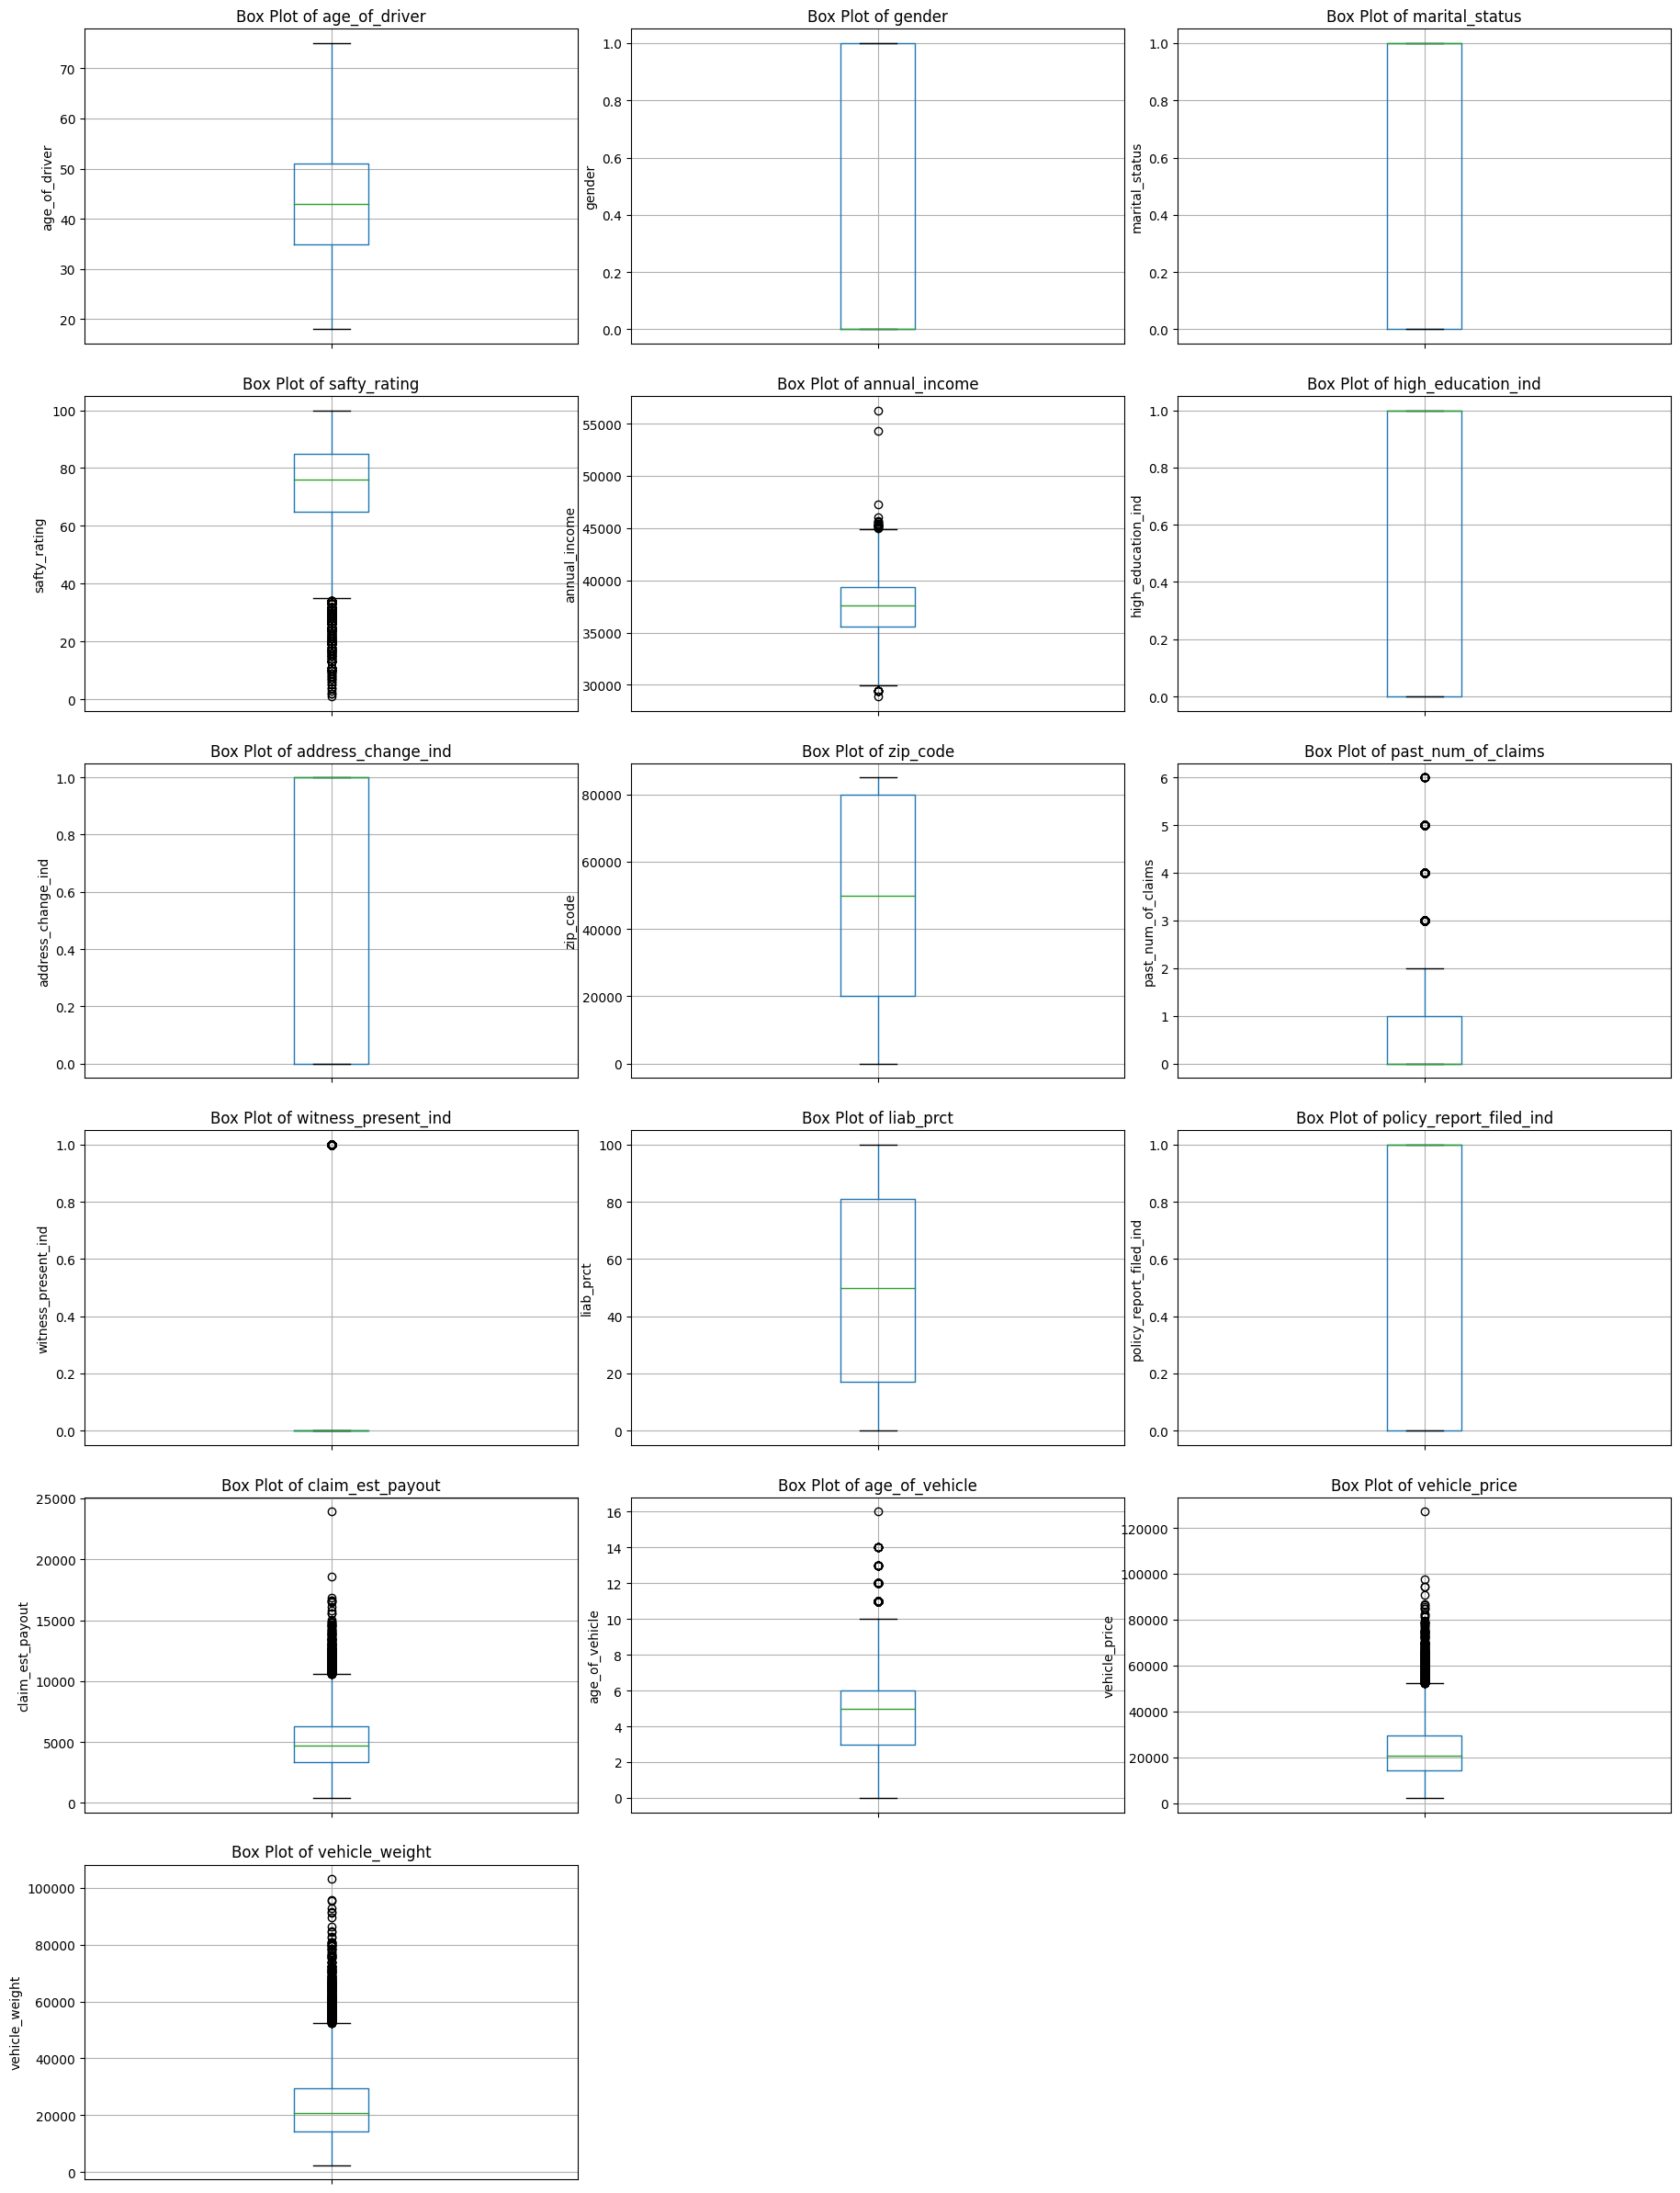

In [ ]:
# this code generates box plots in a nice view by checking the lenth of number of features to be plotted
# and then putting in a for loop to plot the boxplots
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
num_cols = len(numeric_cols)
num_cols_per_row = 3
num_rows = (num_cols + num_cols_per_row - 1) // num_cols_per_row

fig, axes = plt.subplots(num_rows, num_cols_per_row, figsize=(18, num_rows*4))

fig.tight_layout(h_pad=2)

for i, col in enumerate(numeric_cols):
    row = i // num_cols_per_row
    col_idx = i % num_cols_per_row
    ax = axes[row, col_idx]
    X_train.boxplot(column=col, ax=ax)
    ax.set_title('Box Plot of ' + col)
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel(col)

# Hide empty subplots if the number of features is not a multiple of num_cols_per_row
if num_cols % num_cols_per_row != 0:
    for j in range(num_cols % num_cols_per_row, num_cols_per_row):
        fig.delaxes(axes[num_rows-1, j])

plt.xticks(rotation=45)
plt.show()


In [ ]:
# Apply log transform to "vehicle_price" and other attributes that are having outliers
# Log transform is used to handle the outliers

X_train['vehicle_price'] = np.log1p(X_train['vehicle_price'])
X_train['vehicle_weight'] = np.log1p(X_train['vehicle_weight'])
X_train['claim_est_payout'] = np.log1p(X_train['claim_est_payout'])
X_train['safty_rating'] = np.log1p(X_train['safty_rating'])


### Plot 2: Histogram

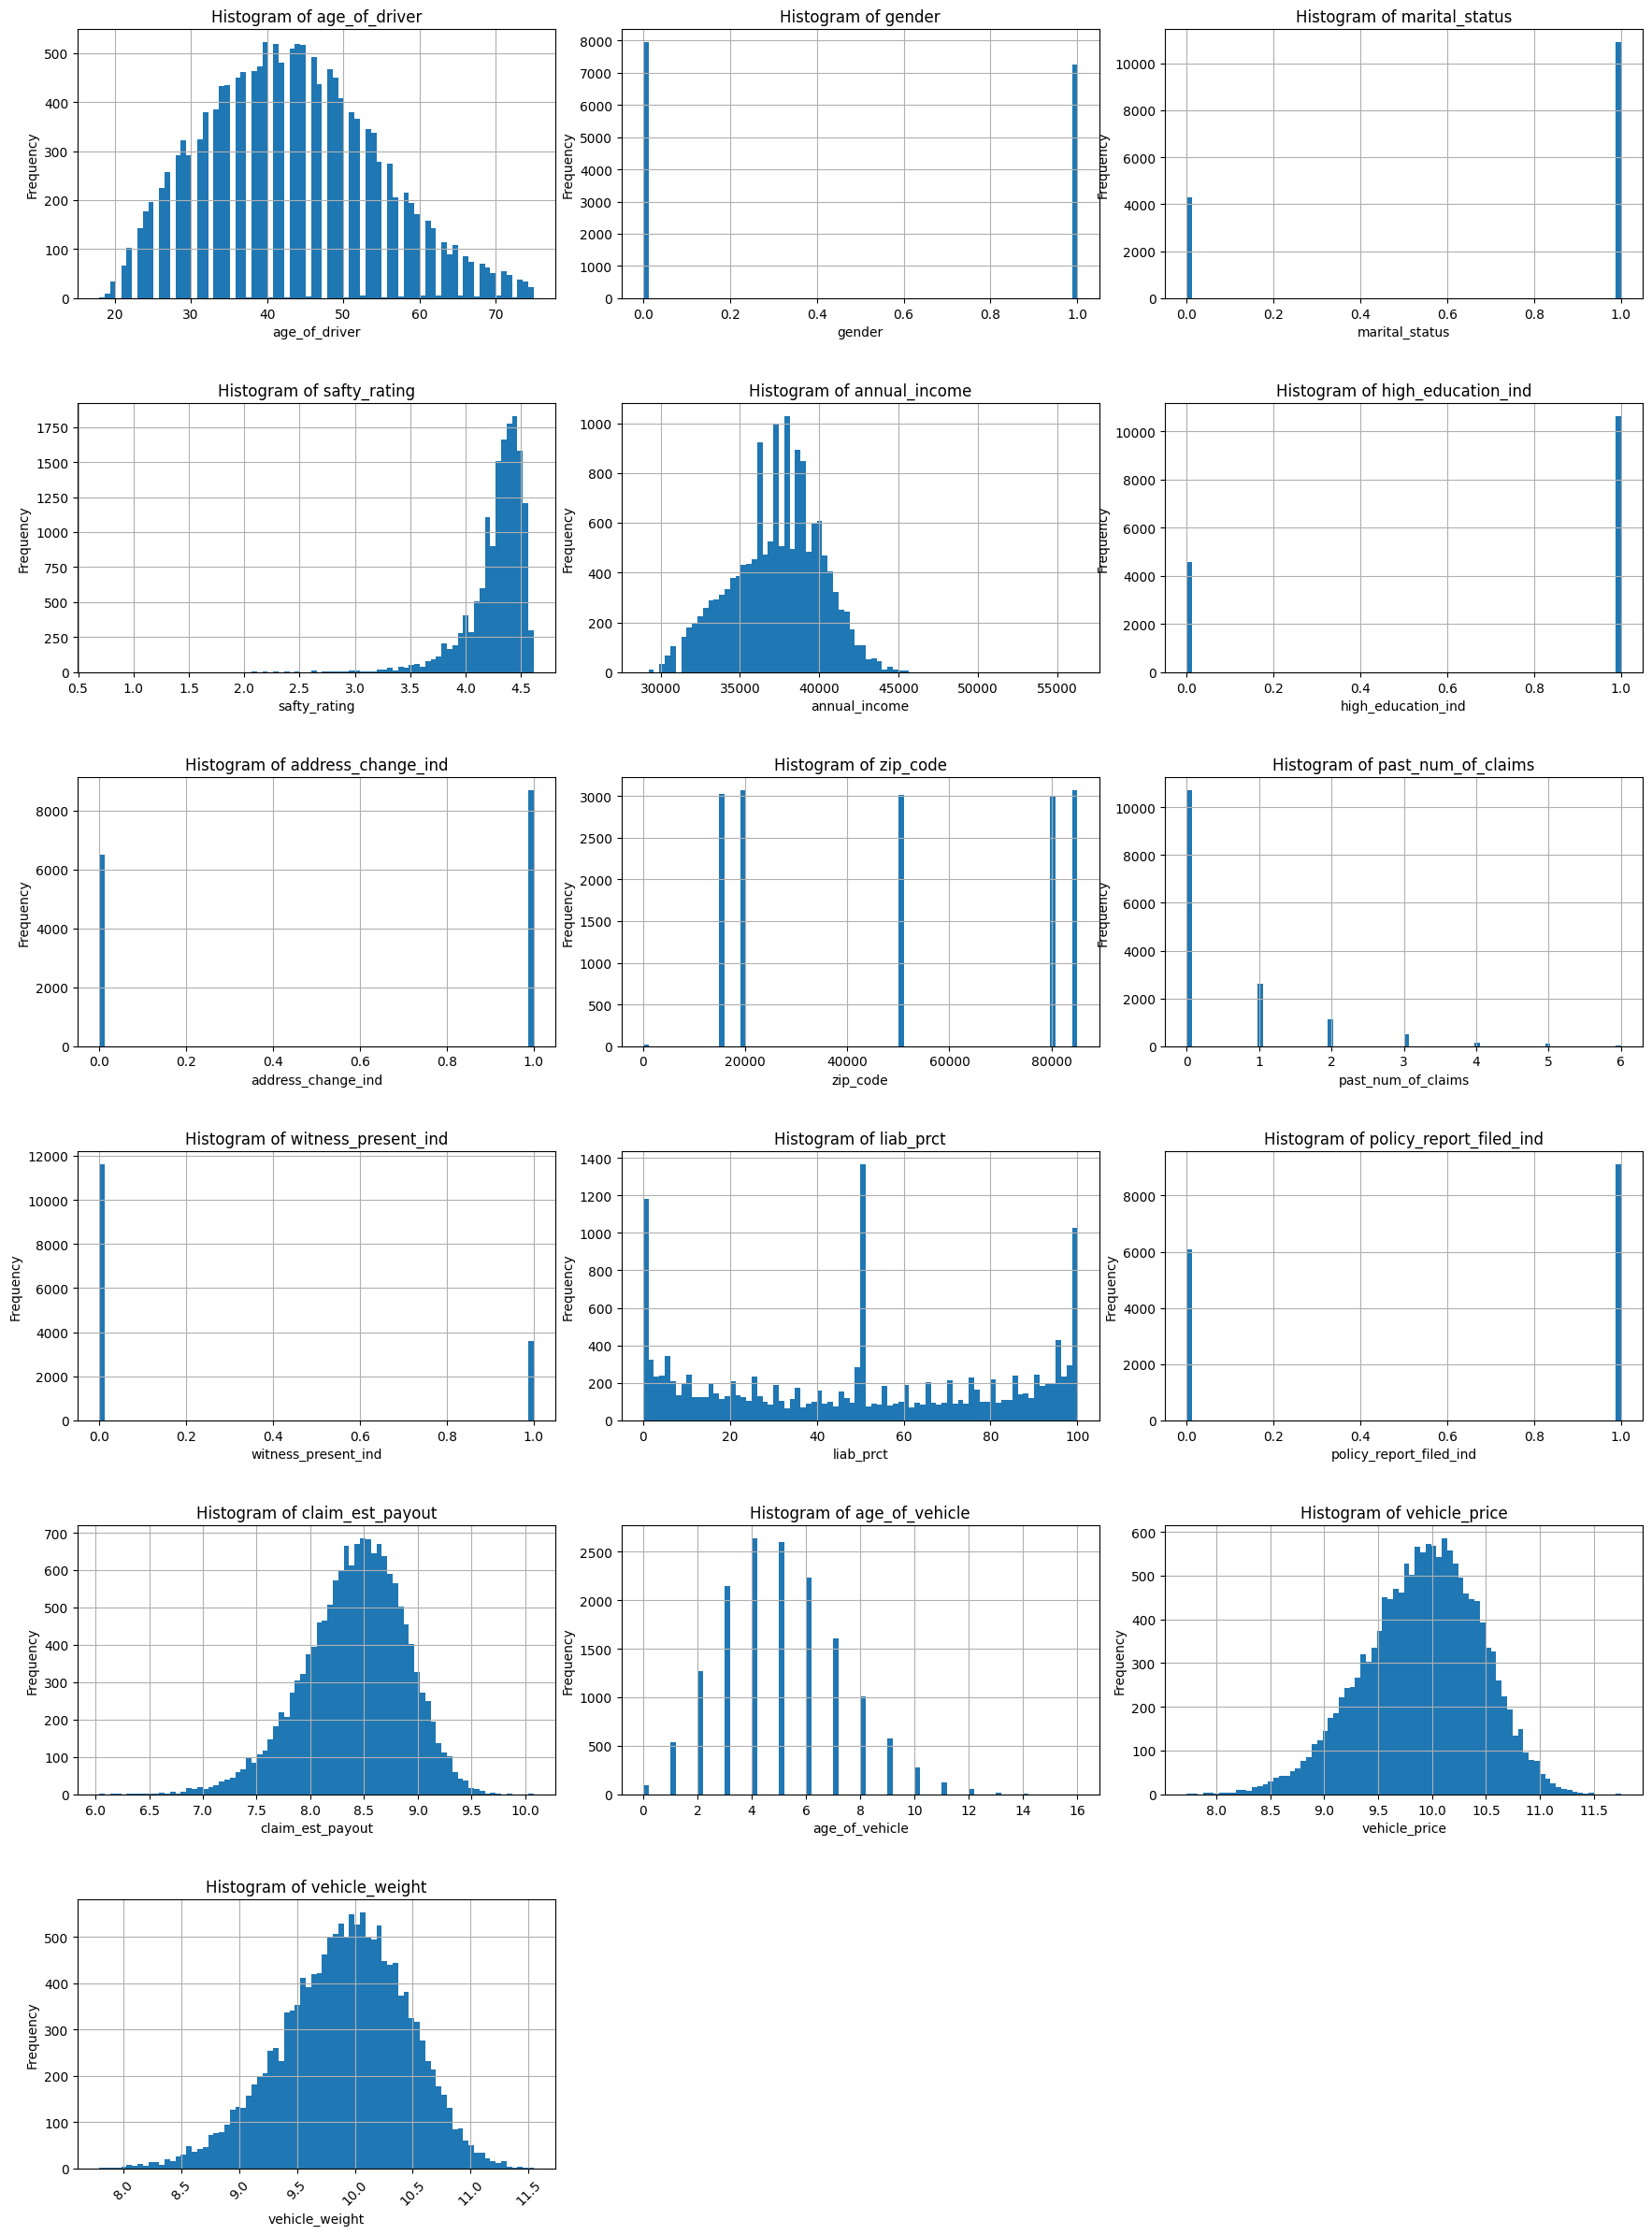

In [ ]:
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
num_cols = len(numeric_cols)
num_cols_per_row = 3
num_rows = (num_cols + num_cols_per_row - 1) // num_cols_per_row

fig, axes = plt.subplots(num_rows, num_cols_per_row, figsize=(18, num_rows*4))

fig.tight_layout(h_pad=6, w_pad=2, pad=3)

for i, col in enumerate(numeric_cols):
    row = i // num_cols_per_row
    col_idx = i % num_cols_per_row
    ax = axes[row, col_idx]
    X_train[col].hist(bins=80, ax=ax)
    ax.set_title('Histogram of ' + col)
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

# Hide empty subplots if the number of features is not a multiple of num_cols_per_row
if num_cols % num_cols_per_row != 0:
    for j in range(num_cols % num_cols_per_row, num_cols_per_row):
        fig.delaxes(axes[num_rows-1, j])

plt.xticks(rotation=45)
plt.show()


### Plot 3: Correlation of features with target variable

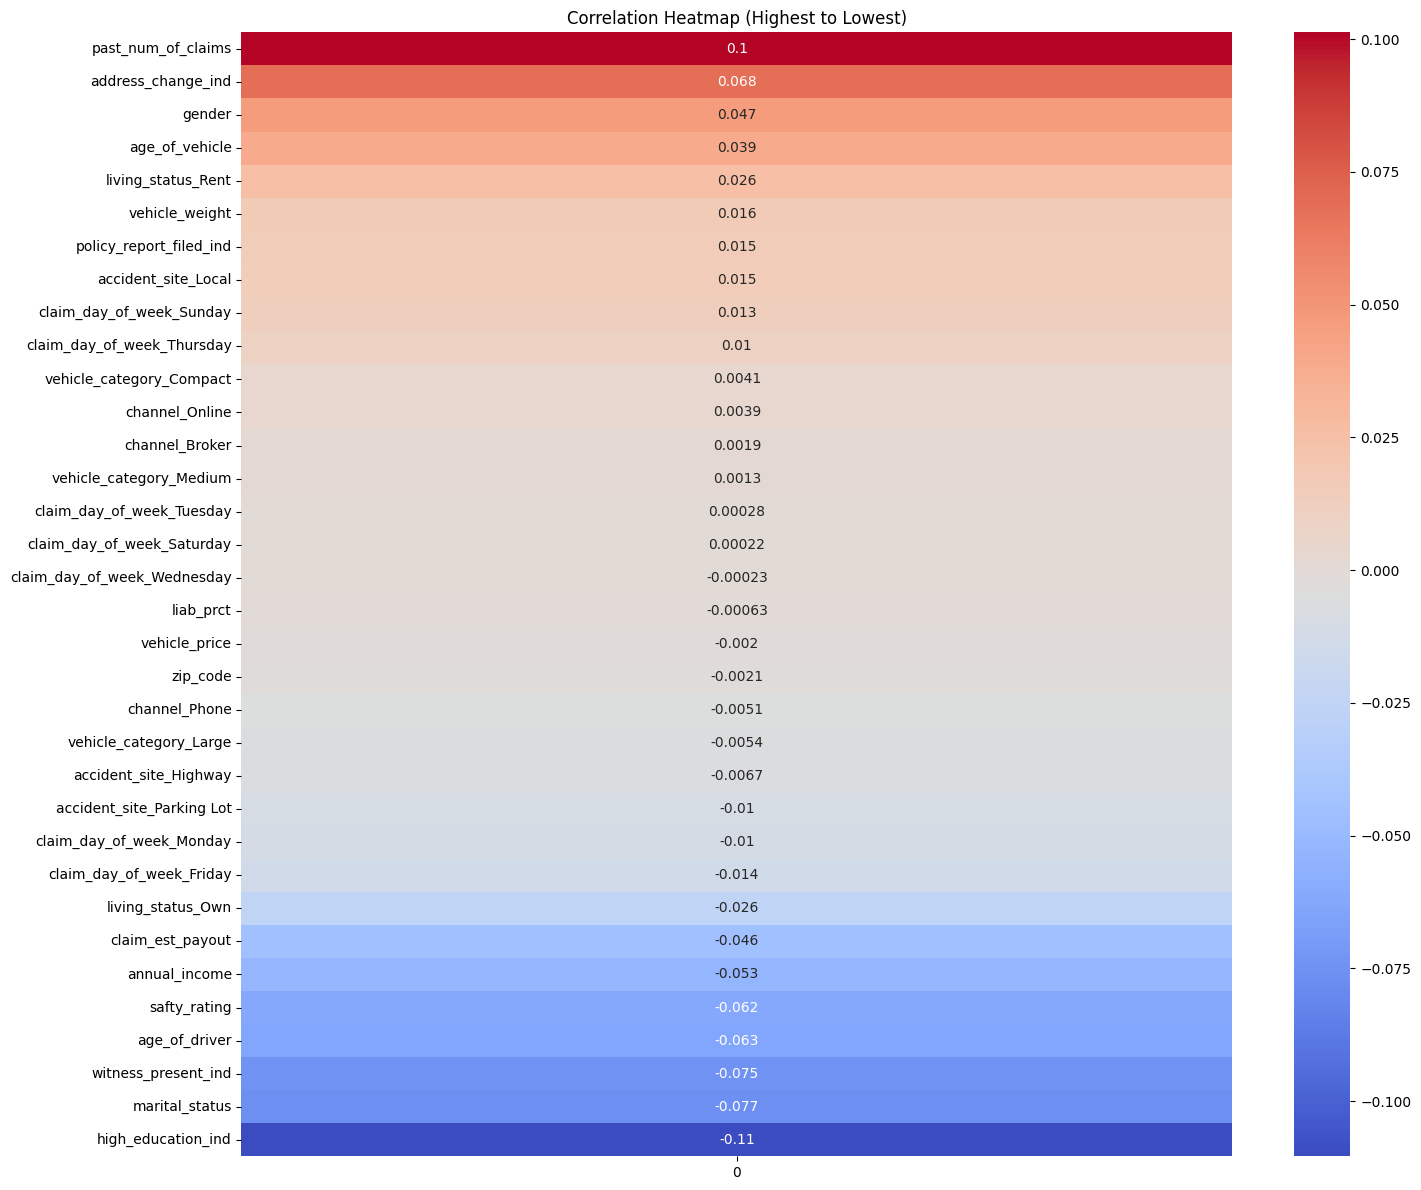

In [ ]:
# Calculate the correlation matrix between X_train features and y_train target variable
corr_matrix = X_train.corrwith(y_train)

# Sort the correlation matrix in descending order
sorted_corr_matrix = corr_matrix.sort_values(ascending=False)

# Create a heatmap of the sorted correlation matrix
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(sorted_corr_matrix.to_frame(), annot=True, cmap='coolwarm', cbar=True, ax=ax)
plt.title('Correlation Heatmap (Highest to Lowest)')
plt.tight_layout()
plt.show()


From the above correlation plot of features and target variable we see that the once that are highly correlated top ten are:

In [ ]:
sorted_corr_matrix.head(10)

past_num_of_claims            0.101298
address_change_ind            0.068253
gender                        0.047392
age_of_vehicle                0.039156
living_status_Rent            0.025649
vehicle_weight                0.016292
policy_report_filed_ind       0.015361
accident_site_Local           0.014694
claim_day_of_week_Sunday      0.013305
claim_day_of_week_Thursday    0.010175
dtype: float64

### Plot 4: Correlation of all Features

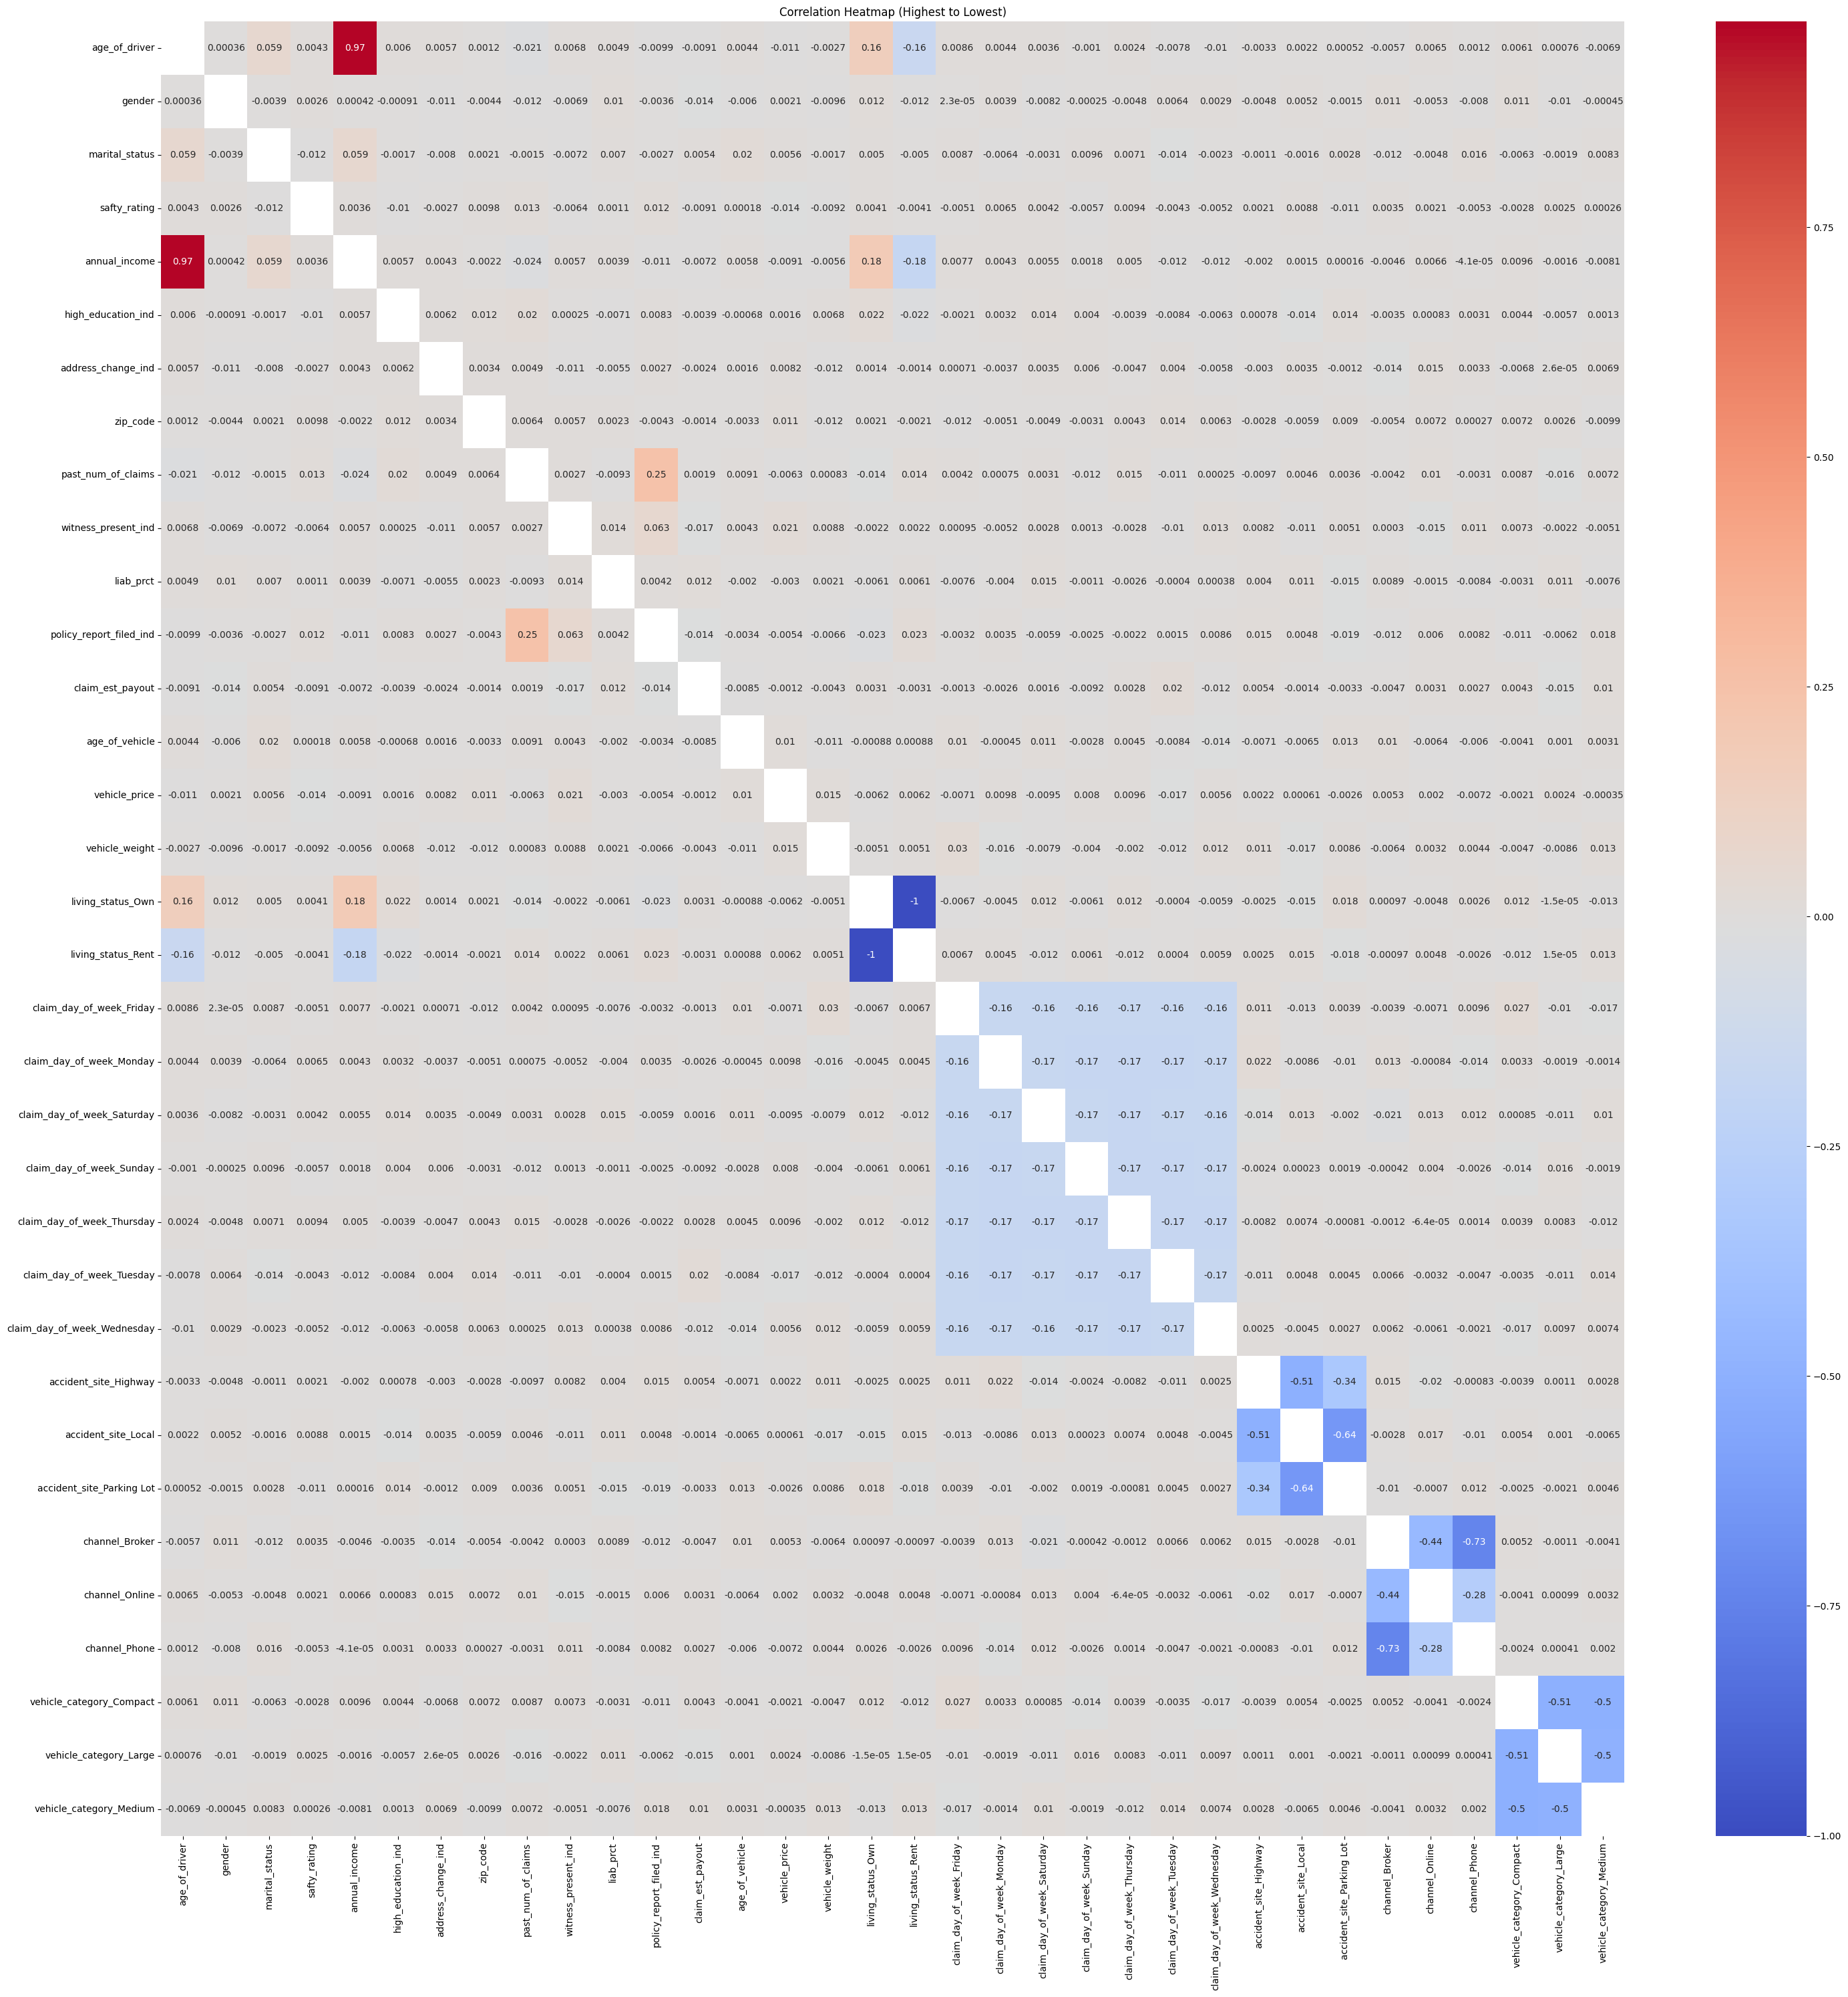

In [ ]:
# Calculate the correlation matrix between X_train features
corr_matrix = X_train.corr()

# Sort the correlation matrix in descending order
sorted_corr_matrix = corr_matrix.unstack().sort_values(ascending=False)

# Remove the correlation values with itself (diagonal elements)
sorted_corr_matrix = sorted_corr_matrix[~(sorted_corr_matrix.index.get_level_values(0) == sorted_corr_matrix.index.get_level_values(1))]

# Create a heatmap of the sorted correlation matrix
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(sorted_corr_matrix.unstack(), annot=True, cmap='coolwarm', cbar=True, ax=ax)
plt.title('Correlation Heatmap (Highest to Lowest)')
plt.tight_layout()
plt.show()


### Plot 5: Density plot of all features

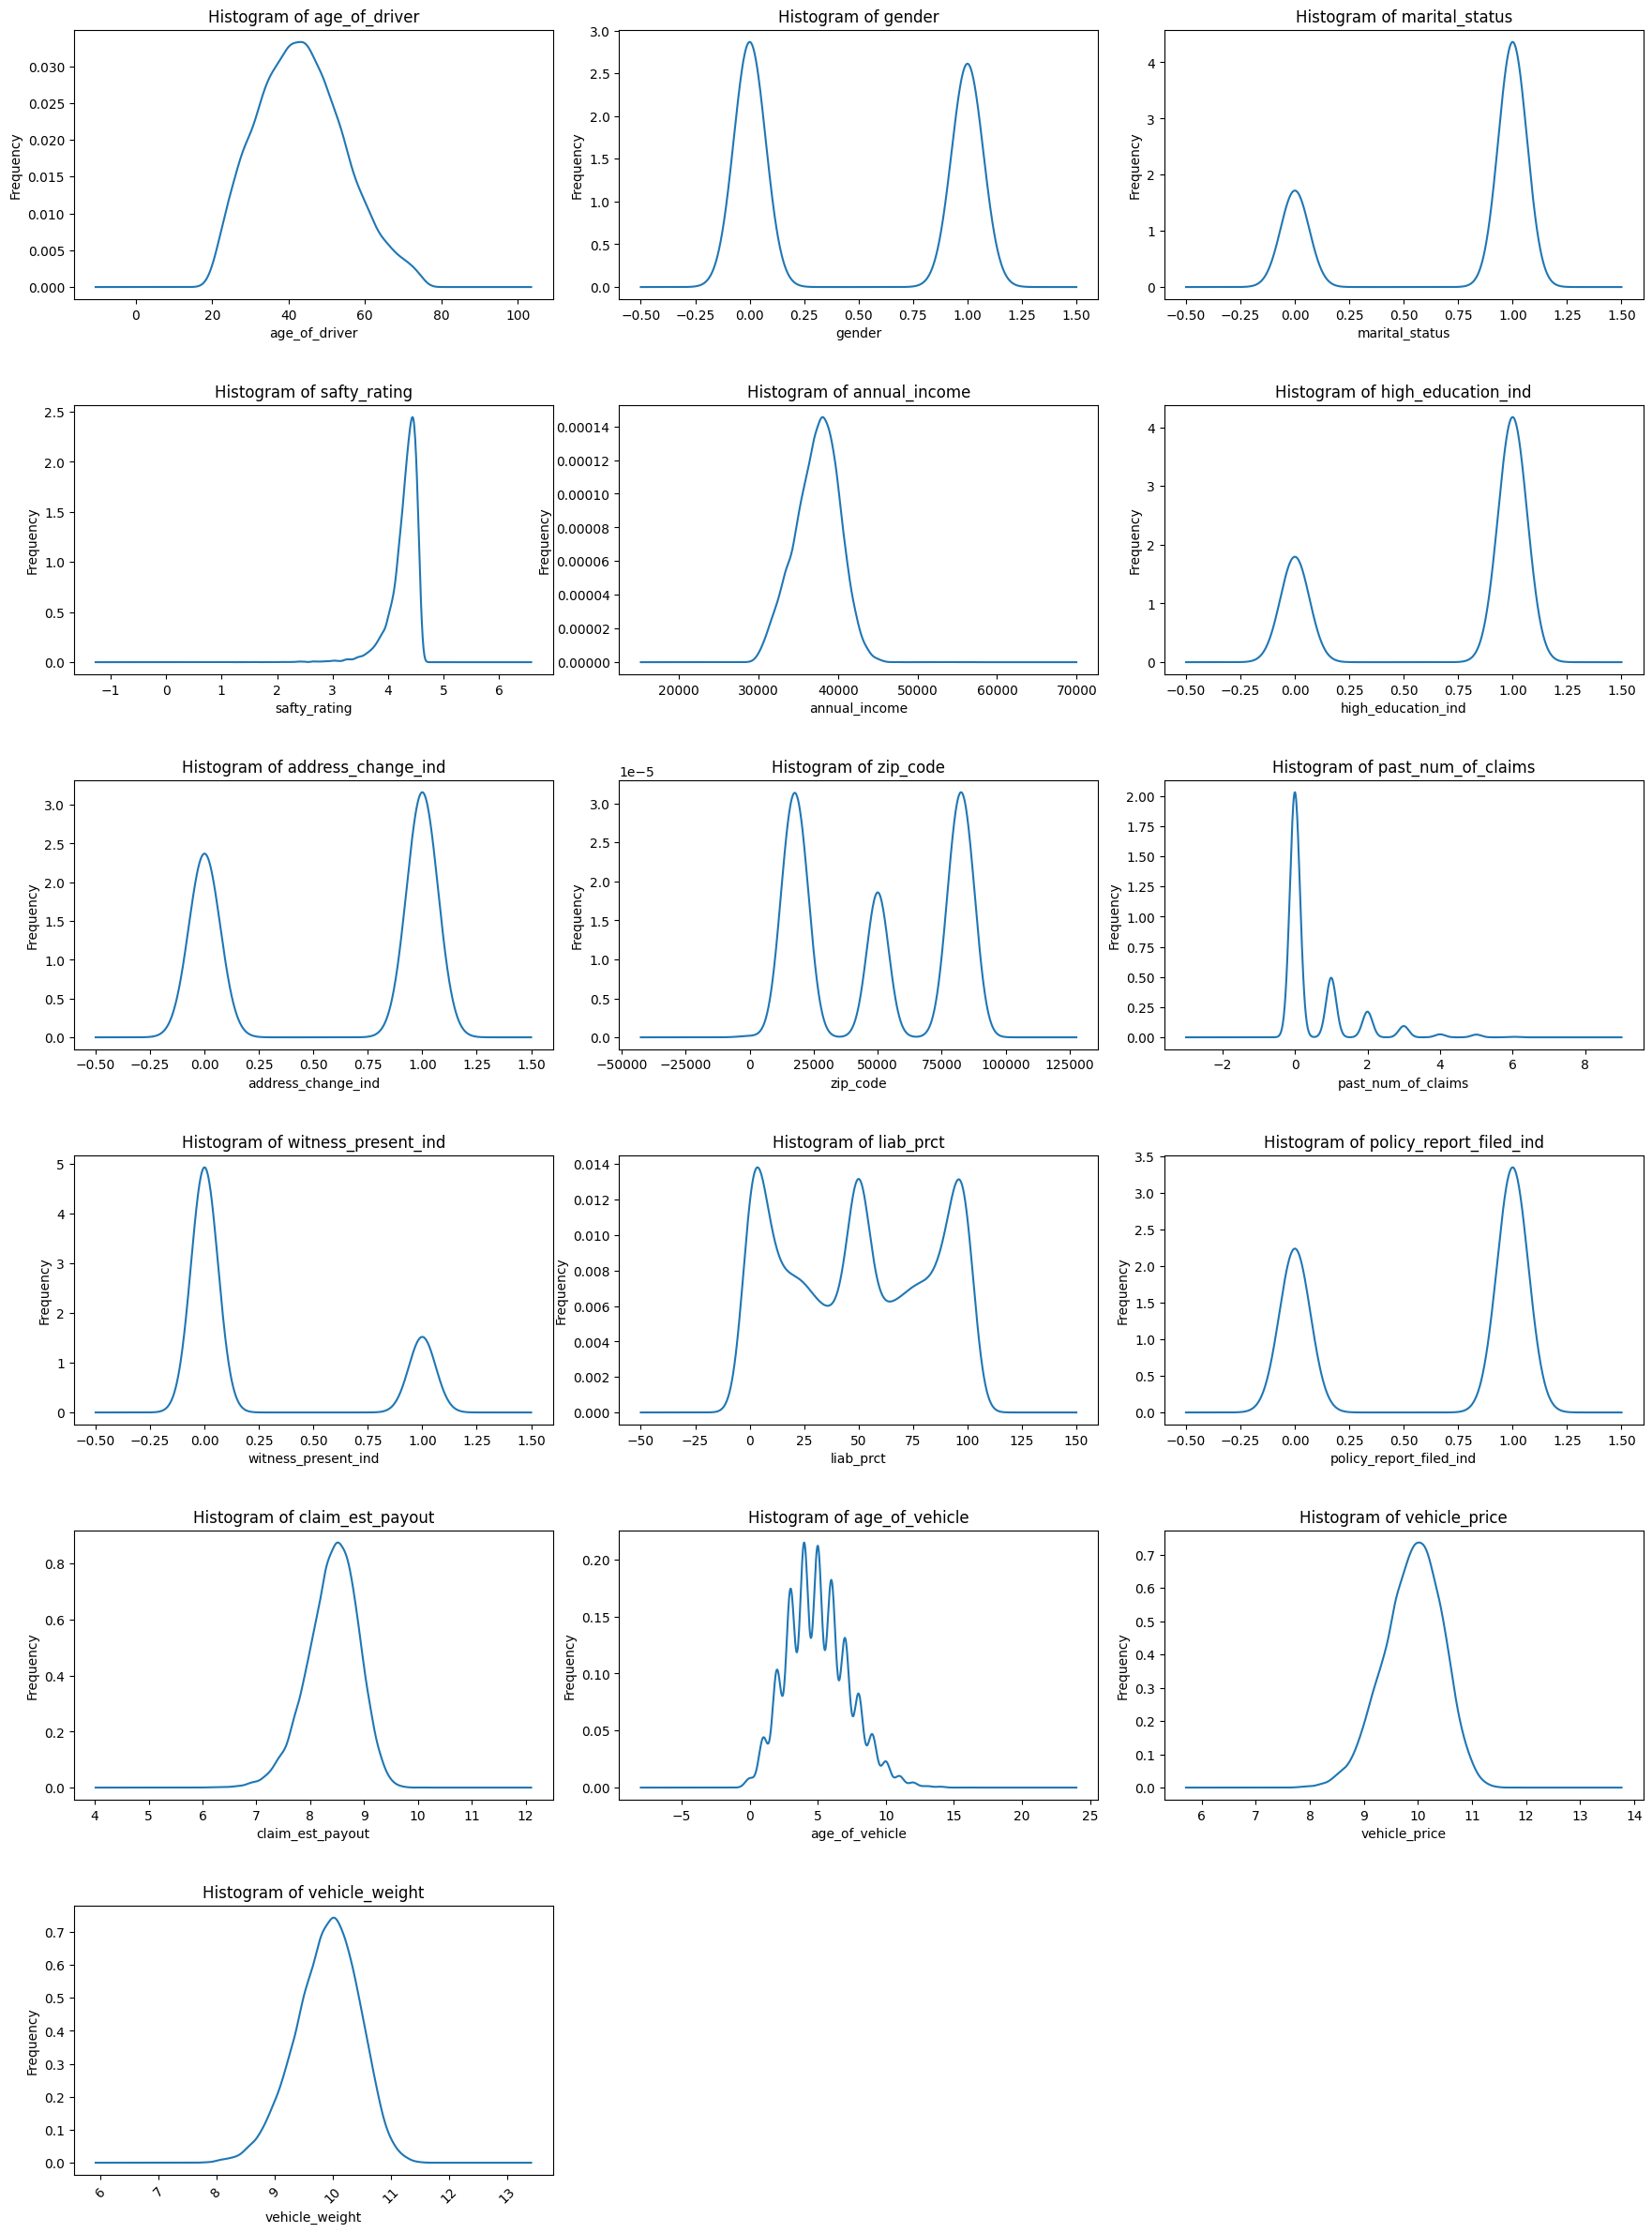

In [ ]:
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
num_cols = len(numeric_cols)
num_cols_per_row = 3
num_rows = (num_cols + num_cols_per_row - 1) // num_cols_per_row

fig, axes = plt.subplots(num_rows, num_cols_per_row, figsize=(18, num_rows*4))

fig.tight_layout(h_pad=6, w_pad=2, pad=3)

for i, col in enumerate(numeric_cols):
    row = i // num_cols_per_row
    col_idx = i % num_cols_per_row
    ax = axes[row, col_idx]
    X_train[col].plot.density(ax=ax)
    ax.set_title('Histogram of ' + col)
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

# Hide empty subplots if the number of features is not a multiple of num_cols_per_row
if num_cols % num_cols_per_row != 0:
    for j in range(num_cols % num_cols_per_row, num_cols_per_row):
        fig.delaxes(axes[num_rows-1, j])

plt.xticks(rotation=45)
plt.show()


### Insights from Visualisation, Plots and Tables:
* From Feature and Target Corelation plot:
  * `past_num_of_claims` is on the top. It is likely that the fraudulent person would often claim or have more claims than the person doing genuine claims
  * `age_of_vehicle` seems to play role in fraud claims as there are chances of more damage to old cars which could be claimed fraudulantly.  
  * Interesting to see that gender female is more correlated than gender Male for fraud claims. lol! lets find out after modelling how feature importance ranks this 😀

  **It is also to be noted that the correlation values are not that significant. This insights are relative among features with target variable**

* From the Histogram and Density plots:
  * Both are analogous but density plot gives a smooth view and ease to capture trends in the features. We can see that the age_of_driver feature has max values till 75 after that the line in density plot goes to 0.

* From Boxplot:
  * There seems to be presence of outliers namely in features
    * vehicle_price
    * claim_est_payout
    * age_of_vehicle
    * past_num_of_claim
    * annual_income
    
  Its possible that this outlier might affect the modelling results.

# Resampling the imbalanced Dataset

In [ ]:
y_train.shape

(15200,)

In [ ]:
#looking at class distribution before resampling
Counter(y_train)

Counter({0: 12853, 1: 2347})

In [ ]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
Counter(y_res)

Counter({0: 12853, 1: 12853})

In [ ]:
y_res.shape

(25706,)

In [ ]:
X_train_copy = X_train.copy()

In [ ]:
X_res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25706 entries, 0 to 25705
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age_of_driver                25706 non-null  float64
 1   gender                       25706 non-null  int64  
 2   marital_status               25706 non-null  int64  
 3   safty_rating                 25706 non-null  float64
 4   annual_income                25706 non-null  float64
 5   high_education_ind           25706 non-null  int64  
 6   address_change_ind           25706 non-null  int64  
 7   zip_code                     25706 non-null  int64  
 8   past_num_of_claims           25706 non-null  int64  
 9   witness_present_ind          25706 non-null  int64  
 10  liab_prct                    25706 non-null  int64  
 11  policy_report_filed_ind      25706 non-null  int64  
 12  claim_est_payout             25706 non-null  float64
 13  age_of_vehicle  

## Standard Scaling

In [ ]:
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_res)
X_test = standard_scaler.transform(X_test)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_res.shape)

(25706, 34)
(3800, 34)
(25706,)


In [ ]:
X_train_copy.head()

,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,zip_code,past_num_of_claims,witness_present_ind,...,claim_day_of_week_Wednesday,accident_site_Highway,accident_site_Local,accident_site_Parking Lot,channel_Broker,channel_Online,channel_Phone,vehicle_category_Compact,vehicle_category_Large,vehicle_category_Medium
6787,46.0,1,1,3.931826,38294.0,1,0,20116,0,0,...,0,0,0,1,1,0,0,0,1,0
6097,35.0,0,1,4.356709,35552.0,0,0,50021,2,0,...,0,1,0,0,0,0,1,0,0,1
11219,63.0,0,1,4.465908,41432.0,0,1,15003,0,0,...,0,0,1,0,0,0,1,1,0,0
2512,47.0,0,1,4.406719,38502.0,1,0,15009,0,1,...,0,0,0,1,1,0,0,0,1,0
4279,37.0,0,1,4.418841,36102.0,0,0,20116,2,1,...,1,0,1,0,1,0,0,1,0,0


# Modelling

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix

RFC = RandomForestClassifier(n_estimators=100,
                             max_depth=5,
                             min_samples_split=5,
                             min_samples_leaf=2)
# or start to 'tinker' :) this is called hyperparameter tuning

# fit the model - one line of code
RFC = RFC.fit(X_train, y_res)

In [ ]:
# store the predictions
train_preds_RFC = RFC.predict(X_train)
test_preds_RFC = RFC.predict(X_test)

In [ ]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

# Modeling Reports

## Classification Report

In [ ]:
# train report
trainReport_RFC = classification_report(y_res, train_preds_RFC)
print(trainReport_RFC)

              precision    recall  f1-score   support

           0       0.83      0.92      0.87     12853
           1       0.91      0.81      0.86     12853

    accuracy                           0.86     25706
   macro avg       0.87      0.86      0.86     25706
weighted avg       0.87      0.86      0.86     25706



In [ ]:
# test report
testReport_RFC = classification_report(y_test, test_preds_RFC)
print(testReport_RFC)

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      3209
           1       0.30      0.19      0.24       591

    accuracy                           0.81      3800
   macro avg       0.58      0.56      0.56      3800
weighted avg       0.77      0.81      0.79      3800



In [ ]:
from sklearn.metrics import f1_score

# Assuming y_true contains the true labels and y_pred contains the predicted labels
# You need to provide the actual true labels and predicted labels for your dataset

# Calculate the weighted F1 score
weighted_f1 = f1_score(y_res, train_preds_RFC, average='weighted')

print("Weighted F1 Score for train:", weighted_f1)

# Calculate the weighted F1 score
weighted_f1 = f1_score(y_test, test_preds_RFC, average='weighted')

print("Weighted F1 Score for test:", weighted_f1)


Weighted F1 Score for train: 0.8627922656295663
Weighted F1 Score for test: 0.7868793585714878


In [ ]:
from sklearn.metrics import confusion_matrix

## Confusion Matrix

In [ ]:
print('Training Confusion  Matrix: \n')
print(confusion_matrix(y_res, train_preds_RFC))

Training Confusion  Matrix: 

[[11781  1072]
 [ 2445 10408]]


In [ ]:
print('Testing Confusion  Matrix: \n')
print(confusion_matrix(y_test, test_preds_RFC))

Testing Confusion  Matrix: 

[[2946  263]
 [ 477  114]]


In [ ]:
accu=accuracy_score(y_test,test_preds_RFC)
accu

0.8052631578947368

#Interpretability and Discussion

## Partial Dependenace and ICE Plots  

In [ ]:
!pip install pulp # for partial dependence plots!
!pip install pycebox
from pycebox.ice import ice, ice_plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
X_test.shape

(3800, 34)

In [ ]:
X_test=pd.DataFrame(X_test)
X_train=pd.DataFrame(X_train)

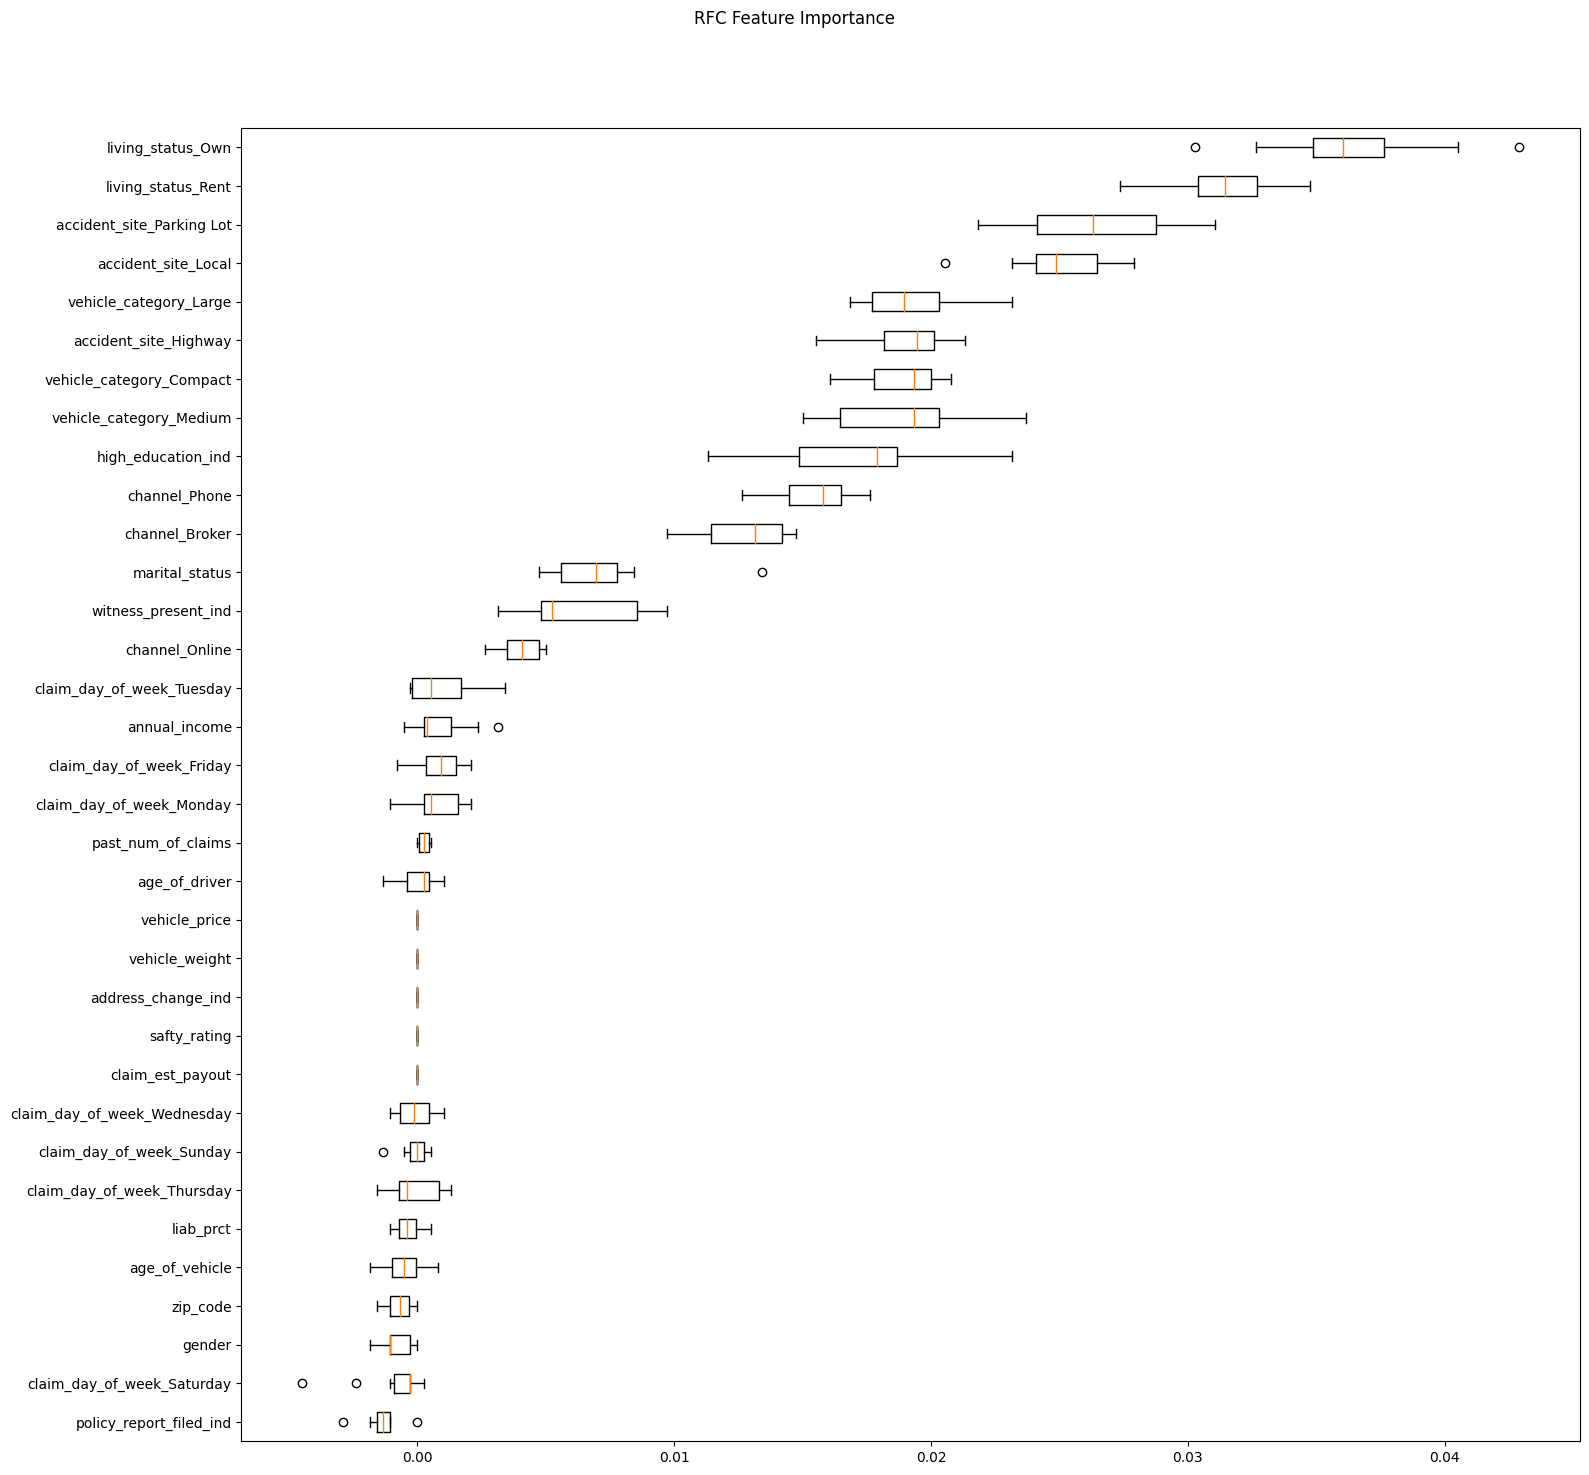

In [ ]:
from sklearn.inspection import permutation_importance
clf = RFC # don't forget to update title!

result = permutation_importance(clf, X_test, y_test, n_repeats=10,
                                random_state=2680937)
perm_sorted_idx = result.importances_mean.argsort()


fig, ax1 = plt.subplots(1, 1, figsize=(16, 14))
ax1.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=X_train_copy.columns[perm_sorted_idx])
ax1.set_yticks(np.arange(1, len(perm_sorted_idx) + 1))
ax1.set_yticklabels(X_train_copy.columns[perm_sorted_idx])
fig.suptitle('RFC Feature Importance', y=1.05) # don't forget to update title!
fig.tight_layout()
plt.show()

In [ ]:
train_X_df = pd.DataFrame(X_res, columns=X_res.columns)
train_X_df.head()

,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,zip_code,past_num_of_claims,witness_present_ind,...,claim_day_of_week_Wednesday,accident_site_Highway,accident_site_Local,accident_site_Parking Lot,channel_Broker,channel_Online,channel_Phone,vehicle_category_Compact,vehicle_category_Large,vehicle_category_Medium
0,46.0,1,1,3.931826,38294.0,1,0,20116,0,0,...,0,0,0,1,1,0,0,0,1,0
1,35.0,0,1,4.356709,35552.0,0,0,50021,2,0,...,0,1,0,0,0,0,1,0,0,1
2,63.0,0,1,4.465908,41432.0,0,1,15003,0,0,...,0,0,1,0,0,0,1,1,0,0
3,47.0,0,1,4.406719,38502.0,1,0,15009,0,1,...,0,0,0,1,1,0,0,0,1,0
4,37.0,0,1,4.418841,36102.0,0,0,20116,2,1,...,1,0,1,0,1,0,0,1,0,0


### 1) PDP Plot 1 - channel_Broker vs Fraud

In [ ]:
tmpdf = ice(data=train_X_df, # ice needs a dataframe
            column='channel_Broker', # the column name
                   predict=RFC.predict, num_grid_points=100) # the predict statement from the
                                          # model
print(np.shape(tmpdf))

(2, 25706)


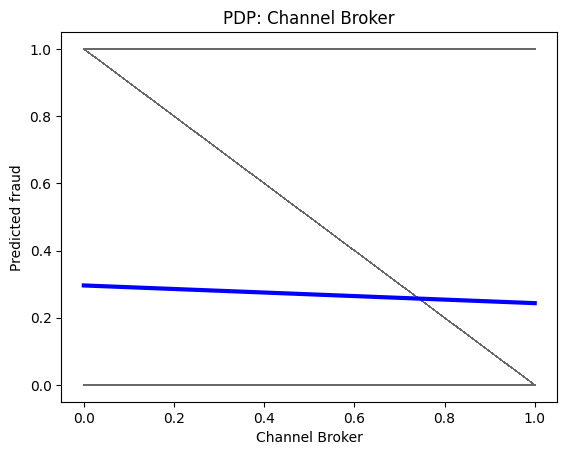

In [ ]:
ice_plot(tmpdf[:1000], c='dimgray', linewidth=0.3,
                  plot_pdp=True,
         pdp_kwargs={'linewidth': 3, 'color':'Blue'})
plt.title('PDP: Channel Broker')
plt.ylabel('Predicted fraud')
plt.xlabel('Channel Broker');
plt.show()

### 2) PDP Plot 2 - channel_Phone vs Fraud

In [ ]:
tmpdf = ice(data=train_X_df, # ice needs a dataframe
            column='channel_Phone', # the column name
                   predict=RFC.predict, num_grid_points=100) # the predict statement from the
                                          # model
print(np.shape(tmpdf))

(2, 25706)


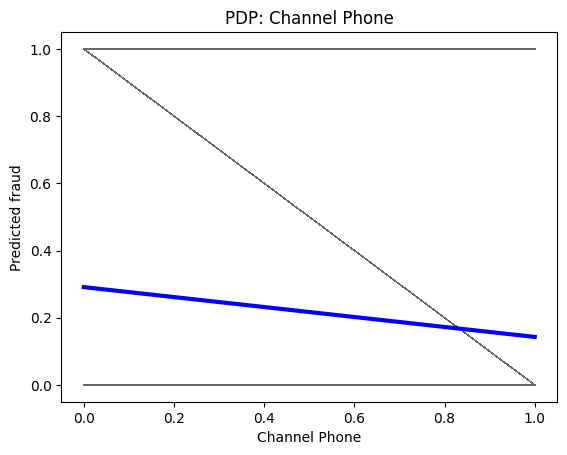

In [ ]:
ice_plot(tmpdf[:1000], c='dimgray', linewidth=0.3,
                  plot_pdp=True,
         pdp_kwargs={'linewidth': 3, 'color':'Blue'})
plt.title('PDP: Channel Phone')
plt.ylabel('Predicted fraud')
plt.xlabel('Channel Phone');
plt.show()

### 3) PDP Plot 3 - living_status_Own vs Fraud

In [ ]:
tmpdf = ice(data=train_X_df, # ice needs a dataframe
            column='living_status_Own', # the column name
                   predict=RFC.predict, num_grid_points=100) # the predict statement from the
                                          # model
print(np.shape(tmpdf))

(2, 25706)


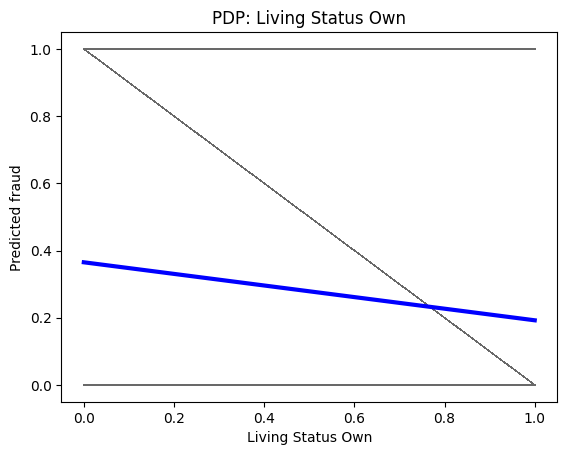

In [ ]:
ice_plot(tmpdf[:1000], c='dimgray', linewidth=0.3,
                  plot_pdp=True,
         pdp_kwargs={'linewidth': 3, 'color':'Blue'})
plt.title('PDP: Living Status Own')
plt.ylabel('Predicted fraud')
plt.xlabel('Living Status Own');
plt.show()

### 4) PDP Plot 4 - living_status_Rent vs Fraud

In [ ]:
tmpdf = ice(data=train_X_df, # ice needs a dataframe
            column='living_status_Rent', # the column name
                   predict=RFC.predict, num_grid_points=100) # the predict statement from the
                                          # model
print(np.shape(tmpdf))

(2, 25706)


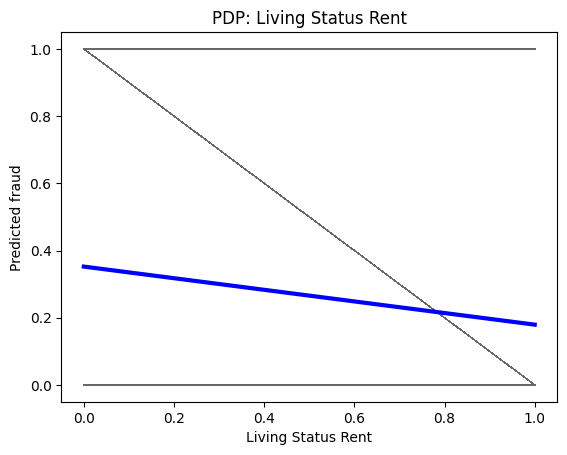

In [ ]:
ice_plot(tmpdf[:1000], c='dimgray', linewidth=0.3,
                  plot_pdp=True,
         pdp_kwargs={'linewidth': 3, 'color':'Blue'})
plt.title('PDP: Living Status Rent')
plt.ylabel('Predicted fraud')
plt.xlabel('Living Status Rent');
plt.show()

### 5) PDP Plot 5 - vehicle_category_Large vs Fraud

In [ ]:
tmpdf = ice(data=train_X_df, # ice needs a dataframe
            column='vehicle_category_Large', # the column name
                   predict=RFC.predict, num_grid_points=100) # the predict statement from the
                                          # model
print(np.shape(tmpdf))

(2, 25706)


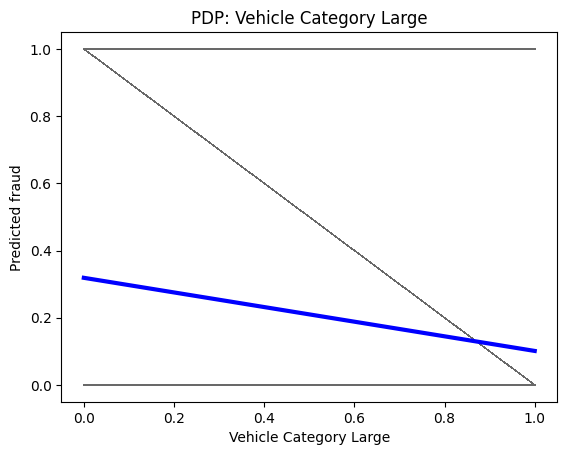

In [ ]:
ice_plot(tmpdf[:1000], c='dimgray', linewidth=0.3,
                  plot_pdp=True,
         pdp_kwargs={'linewidth': 3, 'color':'Blue'})
plt.title('PDP: Vehicle Category Large')
plt.ylabel('Predicted fraud')
plt.xlabel('Vehicle Category Large');
plt.show()

In [ ]:
Features = {'vehicle_category_Compact', 'vehicle_category_Medium', 'accident_site_Local', 'accident_site_Parking Lot', 'high_education_ind'}

In [ ]:
def plot_ice_grid(dict_of_ice_dfs, data_df, features, ax_ylabel='', nrows=4,
                  ncols=4, figsize=(12, 12), sharex=False, sharey=True,
                  num_grid_points = 10,
                  subplots_kws={}, rug_kws={'color':'k'}, **ice_plot_kws):
    """A function that plots ICE plots for different features in a grid."""
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=nrows,
                             ncols=ncols,
                             figsize=figsize,
                             sharex=sharex,
                             sharey=sharey,
                             **subplots_kws)

    # Plot ICE plots for each feature in the grid
    for f, ax in zip(features, axes.flatten()):
        ice_plot(dict_of_ice_dfs[f], ax=ax, **ice_plot_kws)

        # Add a rugplot to show the distribution of the original data
        sns.distplot(data_df[f], ax=ax, hist=False, kde=False,
                     rug=True, rug_kws=rug_kws)
        ax.set_title('feature = ' + f)
        ax.set_ylabel(ax_ylabel)
        sns.despine()

    # Turn off empty subplots
    for i in range(len(features), nrows*ncols):
        axes.flatten()[i].axis('off')

    return fig


<ipython-input-403-a29e3ac87652>:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_df[f], ax=ax, hist=False, kde=False,
<ipython-input-403-a29e3ac87652>:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_df[f], ax=ax, hist=False, kde=False,
<ipython-input-403-a29e3ac87652>:19: UserWarni

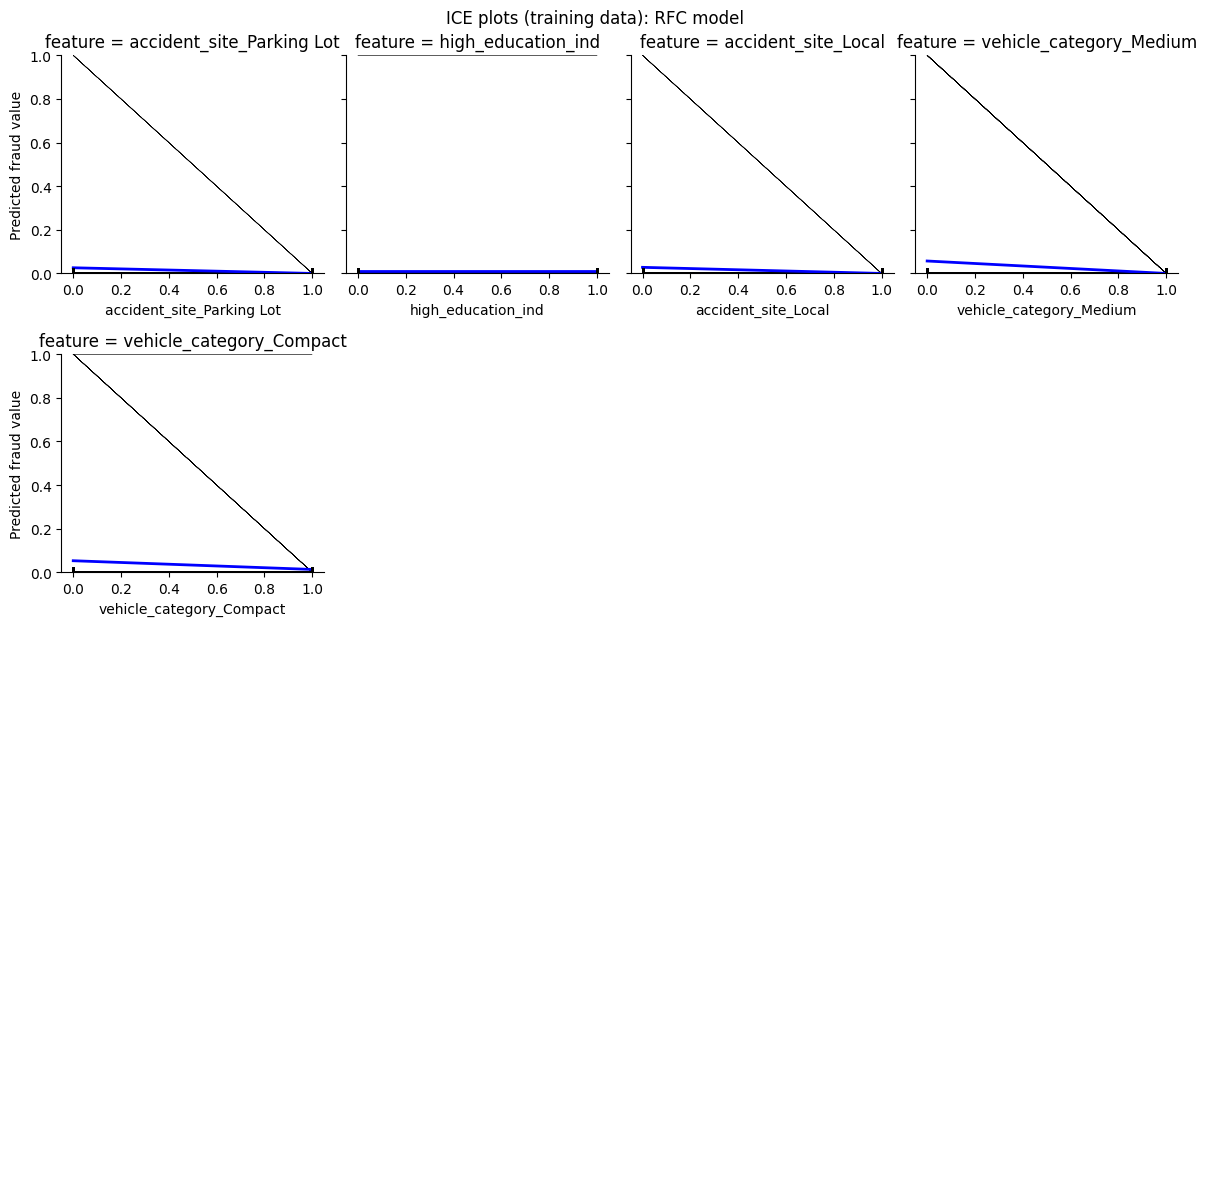

In [ ]:
# Create a dictionary to store the ICE (Individual Conditional Expectation) plots for each feature
# using the ice() function from some library, with predictions made by DTC.predict()
train_ice_dfs = {feat: ice(data=train_X_df[0:1000], column=feat, predict=RFC.predict) for feat in Features}

# Plot the ICE grids using plot_ice_grid() function
plot_ice_grid(train_ice_dfs, train_X_df, Features,
              ax_ylabel='Predicted fraud value', alpha=0.5, plot_pdp=True,
              pdp_kwargs={'c': 'blue', 'linewidth': 2},
              linewidth=0.2, c='black')
plt.xlim([0, 0.8])
plt.ylim([0, 1])
plt.suptitle('ICE plots (training data): RFC model')
plt.subplots_adjust(top=0.89)
plt.tight_layout()

# Interpretability and Discussion

*    After looking at the varaibles listed, we see that the five main areas that are not duplicates, we saw that ** Channel, Higher Education, Vehicle catergory, Living Status and  Accident Site ** were among the most infleuntial. We find this strange but we believe that this is due to there being mutiple catergories for each of these varaibles.

*    In the Ice Plots, we can see a similar trend among all of the top five varaibles as 0 or no values tend to have higher fraud levels than those with 1 or yes values.

*    In the business world, we think it would worthwhile to investigate those the claims reporting channels, espcially those who use a broker, as using a brooker seems to reduce fraud, probably due to experience in the industry.

*    Additionally , we would suggest recoding the variables to be more encompassing, such as for vehicle category being numericwith three level,  1 being a compact and 3 being large.

*    We would also suggest looking into those without higher education, as they seem to be more likely to commit fraud than those with higher eductaion.

*    Overall, we are content with our Random Forest Model but have slight concerns with the predicting of the majority class in our testing samples and also it is detecting some high values for False Positives and Falso Negatives. In the future, we would plan to use more ensemble methods and models to combat these issues, but with out current skill level, we are content with our results.

# Conclusions


*   1. We learned that dealing with unbalanced data is incredibly time consuming and little mistakes can have a large impact on the accuracy of our work. In the future, we plan to right this by dedicating more time to these issues as well as keeping track of what works and what does not so that we can avoid making the same mistakes again.
*   2. We learned that while TPot might be a powerful tool, it can get in the way of our own models. In our case, we spent a large amount of time trying to finetune TPot to generate the best model when we should have focused on making our own models and refining them. Doing this could have saved us sometime on the back end.

*   3. We learned how to wolrk as a team, even though we were seperated by several time zones and a computer screen. Initally, it was difficult to coordinate roles as day and night were swapped for us but we learned in a relativley short period of time how to coordinate with each other and do work while the others were sleeping. It meant several late night and early mornings, but we eventaully came up with a system that worked.  
*  4. We learned the importance of making and naming copies of our notebooks and that while GoogleCollab is great for sharing and editing code, it can be very dificult to work with when multiple people are working on the same notebook or have several notebooks with similar names. One thing that we plan to do moving forward is saving the file as we go along so that we have an untouched version we can go back to. Additionally, naming conventions are important as is saving as you go, so that hours of work are not lost in the process.


*   5. Fraud is prevalent across all education levels. While it might be more intricate for those with higher education, it should be considered when looking at any policyholder


*   6. Finally, we learned how to make compromises. When you are working as a team, indecision can eat up a lot of time and it is best to be able to come together as a team and decide when it is time to move on. We learned a greeat deal about how you can spend large amounts of time trying to make everything perfect but when faced witha time constraint, it is vital to know when to say it is good enough. For example, we faced an error where we kept over fitting our testing sample to the majority class and while were abel to improve this, we decided that due to the time constraits, it would be more effective to set a stopping time on that part so that we could finish the rest of the project.





*  Overall, we learned a great deal and had a challenging and educational experiment trying to put all we learned over the past month into practice and we are sure that with more practice, we could make even more improvements in the future.


# Business Recommendation

*   We suggest that to reduce fraudulent claims, prioritize broker training and invest in strengthening online systems for claim reporting. This will enhance fraud detection capabilities and ensure a more robust and secure claims process across different channels.


# Rubric
The submitted notebook will serve as both a form of model documentation and business communication - there should be lots of text cells and comments and a nice presentation of your work. Do not send sloppy code and think you'll be fine - pretend this document is going to your AVP of Data Science - It should be both technical and business-friendly. If you send me garbage, your grade will be garbage!

## EDA, data cleaning and feature engineering (20 points)
* `X_train`, `X_test`, `y_train`, and `y_test` has been provided to all students.
  * Any team who does not do this automatically goes into last place - more below!
* Explore the data and clean it up as you see fit - make sure you `fit_transform()` on the training data and `transform()` on the test data.
  * Any team that has data leakage automatically goes into last place!
* Make five meaningful plots and five meaningful tables (most be deeper than simpler univariate plots - we want you to really explore the problem at hand and use this information to make a better model!)
* It is up to you whether or not you want to curate the training dataset to get a better fit on the test dataset (for example, if you would like to use some sampling strategy like SMOTE, that's great - just remember that you DON'T change the distribution of the target variable in the test partition.)

## Modeling (20 points)
* You may perform your modeling in a different notebook (to be submitted as an appendix), but you must run your final and BEST model here and all output must be displayed.
  * It's up to you to decide what the best pre-processing steps should be!

## Model Results (20 points)
* Classification report and confusion report for train and test partition.
  * You may use cross-validation to help pick the optimal hyperparameters for your model.
  * You may change the classification threshold from 0.5 to anything else that improves your score.
* Verify your shape of the test partition to ensure there is no data leakage!

## Interpretability and Discussion (30 points)
* Create permutation importance for top five variables
* Create partial dependence plots for top five variables
  * Don't forget about the `num_grid_points` argument to your PDP if it takes a long time to make the plot.
  * Don't wait until the last minute and say your code was crashing - work on this early or I have to deduct points!
* You may add other tables/plots/analyses to help tell your story!
*  Use your model results and interpretability items to present what variables are most influential in causing a policy cancellation.
  * We are looking for each team to provide a business recommendation based on the results of your model! We will take off substantial points if there is not a well-written and cohesive presentation of results.

## Conclusions (10 points)
* Write five meaningful bullets (each bullet should be at least two sentences long) describing what you learned.
  * Don't use ChatGPT or you get 0 points for this.

## 🛷 Sliding grading scale
* You are in direct competition with every other group in the class!
* I expect everything in this notebook to be of sufficient quality - well-organized with lots of comments and cleaned up nice for presentation to management. I will deduct substantial points if this is just my code copy/pasted without any deep analysis.
* Your 'starting grades' will range from an 80 to a 100 based on model F1 score for the TEST PARTITION (you can use the `F1 score` function from sci-kit learn to evaluate the final model.)
* Of course, if something is missing from the above rubric, we will deduct points from your starting grade.
  * If you came in first place and lost 10 points somewhere, your final grade is 100 - 10 = 90
  * If you came in last place (for accuracy) and lost 10 points somewhere, your final grade is 80 - 10 = 70.


Please use nice big, descriptive subheaders so that it is easy to grade! Thank you!

# APPENDIX

## Grid search we performed

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV

# # Create a Random Forest Classifier
# rfc = RandomForestClassifier()

# # Define the parameter grid for tuning
# param_grid = {
#     'n_estimators': [50, 100, 150, 200],
#     'max_depth': [2, 5, 10, None],
#     'min_samples_split': [1, 2, 5, 10, 15],
#     'min_samples_leaf': [1, 2, 4, 5, 10],
# }

# # Perform randomized search cross-validation
# random_search = RandomizedSearchCV(rfc, param_distributions=param_grid, cv=5, n_iter=20)
# random_search.fit(X_train, y_res)

# # Print the best parameters and best score
# print("Best Parameters:", random_search.best_params_)
# print("Best Score:", random_search.best_score_)

## Other Classification Model we tried

### Gradient Boosting

In [ ]:
# GBC = GradientBoostingClassifier(learning_rate=0.02, max_depth=5, n_estimators=300)
# GBC = GBC.fit(X_train, y_res)
# # Store the predictions
# train_preds_GBC = GBC.predict(X_train)
# test_preds_GBC = GBC.predict(X_test)

In [ ]:
# train report
# trainReport_GBC = classification_report(y_res, train_preds_GBC)
# print(trainReport_GBC)

In [ ]:
# # test report
# testReport_GBC = classification_report(y_test, test_preds_GBC)
# print(testReport_GBC)